# 1、Environmental plot

## 1.0 Load data

In [ ]:
from matplotlib import pyplot as plt
from function import *
from function.global_varibles import *
import glob
import geopandas as gpd
from shapely.geometry import Point
import pandas as pd
import numpy as np


df_analysis=pd.read_csv(r'data\US_data\df_merged_data_for_analysis.csv')
df_economic = pd.read_csv('data/US_data/df_economic.csv')



# 环境维度的变量
env_data = df_analysis[['lat', 'lon', 'predicted_prob','gmm_density','sample_type']].copy()

# 碳减排维度的变量

emission_data = df_analysis[['lat', 'lon', 'Expectation_net_benefit','area_m2']].copy()
emission_data['Expectation_net_benefit'] = emission_data['Expectation_net_benefit'] * 3.67  # 单位变为MgCO2也就是吨
emission_data = emission_data.rename(columns={'Expectation_net_benefit': 'Expectation_net_benefit'})

# 经济维度的变量
economic_2050 = df_economic[df_economic['analysis_year'] == 2050]
avg_npv = economic_2050.groupby(['lat', 'lon'])['net_npv_usd'].mean().reset_index().rename(columns={'net_npv_usd': 'avg_npv'})


# 合并所有变量
merged_data_for_plot = env_data.merge(emission_data, on=['lat', 'lon'], how='outer') \
                      .merge(avg_npv, on=['lat', 'lon'], how='outer')
merged_data_for_plot

                      

In [ ]:
import geopandas as gpd
import rioxarray
from shapely.geometry import mapping
import matplotlib.pyplot as plt
import numpy as np
from io import BytesIO



us_nation = gpd.read_file(r'data\US_data\cb_2018_us_nation_5m.shp')
us_states = gpd.read_file(r'data\cb_2018_us_state_500k.shp')
us_counties = gpd.read_file('data/cb_2018_us_county_500k.shp')


us_nation_4326 = us_nation.to_crs('EPSG:4326')
us_states_4326 = us_states.to_crs('EPSG:4326')
us_counties_4326 = us_counties.to_crs('EPSG:4326')

# 2. 读取DEM并设置CRS（如果缺失）
dem = rioxarray.open_rasterio(r'figure\draw_shp\DEM.nc', masked=True)

# 检查DEM的CRS，如果缺失则手动设置
if dem.rio.crs is None:
    # 根据DEM数据的坐标范围判断，通常全球DEM使用EPSG:4326
    print("DEM CRS缺失，设置为EPSG:4326")
    dem = dem.rio.write_crs("EPSG:4326")

# 3. 确保US nation的CRS与DEM一致
if us_nation.crs != dem.rio.crs:
    print(f"转换US nation CRS从 {us_nation.crs} 到 {dem.rio.crs}")
    us_nation = us_nation.to_crs(dem.rio.crs)



# 4. 用us_nation精确裁剪DEM
print("开始裁剪DEM（使用us_nation）...")
dem_us = dem.rio.clip(us_nation.geometry.apply(mapping), us_nation.crs, drop=True)
print("DEM裁剪完成！")





## 1.1 Help funciton

In [ ]:

def _render_terrain(ax, dem_data, usa_bounds_main, transformer):
    """渲染地形"""
    qm = None
    dem_lon = dem_data.x.values
    dem_lat = dem_data.y.values
    lon_mask = (dem_lon >= usa_bounds_main['lon_min']) & (dem_lon <= usa_bounds_main['lon_max'])
    lat_mask = (dem_lat >= usa_bounds_main['lat_min']) & (dem_lat <= usa_bounds_main['lat_max'])
    
    if lon_mask.any() and lat_mask.any():
        lon_idx = np.where(lon_mask)[0]
        lat_idx = np.where(lat_mask)[0]
        
        # 抽稀栅格
        step_x = max(1, len(lon_idx)//1800)
        step_y = max(1, len(lat_idx)//900)
        lon_sub = lon_idx[::step_x]
        lat_sub = lat_idx[::step_y]
        elev = dem_data.squeeze().values[np.ix_(lat_sub, lon_sub)]

        mask = ~np.isnan(elev)
        if mask.any():
            lo = np.nanpercentile(elev, 35)
            elev[elev < lo] = np.nan

            # 地形配色
            terrain_colors = ListedColormap(["#ffffff", "#eef3ef", "#dfe8e0",
                                           "#d2ddcf", "#c7d1c1", "#b7c2af"])
            terrain_colors.set_bad((0, 0, 0, 0))
            qs = np.nanpercentile(elev, [35, 50, 65, 78, 88, 98])
            norm = BoundaryNorm(qs, terrain_colors.N)

            lon_grid, lat_grid = np.meshgrid(dem_lon[lon_sub], dem_lat[lat_sub])
            gx, gy = transformer.transform(lon_grid, lat_grid)            
            qm = ax.pcolormesh(gx, gy, elev, cmap=terrain_colors, norm=norm,
                              shading='auto', alpha=0.55, antialiased=False, zorder=1)
            qm.set_clip_on(True)
    
    return qm


def _draw_glow_outline_outside(ax, gdf_albers, line_color="#444444", line_width=0.8,
                              widths_km=(0, 30, 50), alphas=(0.95, 0.5, 0.3), 
                              colors=("#08336e", "#105ca4", "#3888c0")):
    """绘制国界线光晕效果"""
    g = gdf_albers.copy()
    geom = unary_union(g.geometry)
    
    if make_valid is not None:
        geom = make_valid(geom)
    else:
        geom = geom.buffer(0)

    radii_m = [k*1000.0 for k in widths_km]
    ordered = list(zip(radii_m, alphas, colors))
    ordered.sort(key=lambda x: x[0])

    last_inner = geom.buffer(0, join_style=2, cap_style=2)
    glow_meshes = []
    
    for i, (r, alpha, color) in enumerate(ordered):
        outer = geom.buffer(r, join_style=2, cap_style=2)
        ring = outer.difference(last_inner)
        if not ring.is_empty:
            glow_series = gpd.GeoSeries([ring], crs=g.crs)
            glow_mesh = glow_series.plot(ax=ax, color=color, alpha=alpha, edgecolor="none",
                                       zorder=8.2 + i*0.01)
            glow_meshes.append(glow_mesh)
        last_inner = outer

    g.boundary.plot(ax=ax, color=line_color, linewidth=line_width, zorder=9.6)
    return glow_meshes



def _draw_background_map(ax, usa_bounds_main):
    """绘制背景地图"""
    try:
        bbox_expanded = box(
            usa_bounds_main['lon_min'] - 3, usa_bounds_main['lat_min'] - 3,
            usa_bounds_main['lon_max'] + 3, usa_bounds_main['lat_max'] + 3
        )
        helper_gdf = gpd.read_file(r'figure\draw_shp\ne_110m_land.shp').to_crs(4326)
        helper_gdf = helper_gdf.clip(bbox_expanded)
        
        if 'featurecla' in helper_gdf.columns:
            helper_gdf = helper_gdf[helper_gdf['featurecla'].str.contains('Land', na=False)]
        
        if make_valid is not None:
            helper_gdf['geometry'] = helper_gdf.geometry.map(make_valid)
        else:
            helper_gdf['geometry'] = helper_gdf.geometry.buffer(0)
            
        helper_gdf = helper_gdf[helper_gdf.geometry.geom_type.isin(['Polygon', 'MultiPolygon'])]
        helper_gdf = helper_gdf.explode(index_parts=False, ignore_index=True)
        helper_gdf_proj = helper_gdf.to_crs('ESRI:102003')
        helper_gdf_proj['geometry'] = helper_gdf_proj.buffer(0)
        helper_gdf_proj.plot(ax=ax, facecolor='white', edgecolor='lightgray',
                           linewidth=0.3, alpha=1, zorder=0.5)
    except Exception as e:
        print(f"Helper map error: {e}")

def _add_colorbar(fig, ax, scatter, var_bins, variable_name, unit, var_values, colors):
    """添加颜色条到背景地图下方，并在上方显示数据分布曲线+柱状图"""
    def add_horizontal_cbar_equiv(fig, ax, mappable, var_bins, variable_name, unit_display=None, var_values=None, colors=None):
        # 获取主地图位置
        pos = ax.get_position()
        
        # colorbar放在底部，背景地图下方
        left = pos.x0 + 0.2 * pos.width
        bottom = 0.1  # 固定在底部
        width = 0.55 * pos.width
        height = 0.035  # colorbar高度

        cax = fig.add_axes([left, bottom, width, height])
        cax.set_in_layout(False)
        cax.set_zorder(50)  
        cb = fig.colorbar(mappable, cax=cax, orientation='horizontal')

        cb.set_ticks(var_bins[1::2])

        # 格式化刻度标签
        tick_vals = var_bins[1::2]
        if variable_name == 'avg_npv':
            tick_labels = [f'{v/1_000:.2f}' for v in tick_vals]
        elif variable_name == 'predicted_prob':
            tick_labels = [f'{v:.2f}' for v in tick_vals]
        elif variable_name == 'Expectation_net_benefit':
            tick_labels = [f'{v/1_000:.2f}' for v in tick_vals]
        else:
            tick_labels = [f'{v:.0f}' for v in tick_vals]
        cb.set_ticklabels(tick_labels)

        # 细长
        cax.tick_params(axis='x', which='major', length=2.5, width=0.5, pad=1, labelsize=5)
        cax.tick_params(axis='x', which='minor', length=1.5, width=0.4, label1On=False)
        cb.outline.set_linewidth(0.7)

        # 百分位标签
        percentile_labels = [f'Top{p}' for p in range(10, 101, 20)][::-1]
        major_tick_locs = cb.get_ticks()
        for loc, label in zip(major_tick_locs, percentile_labels):
            # 使用colorbar坐标系统的正确定位方式
            x_disp = cax.transData.transform((loc, 0))[0]
            x_frac = cax.transAxes.inverted().transform((x_disp, 0))[0]
            cax.text(x_frac, 1.15, label, transform=cax.transAxes,
                    ha='center', va='bottom', fontsize=5, clip_on=False)
        cax.text(1.08, 1.3, "(%)", ha='center', va='bottom', fontsize=5, 
                fontweight='bold', transform=cax.transAxes)

        # ========== 添加数据分布曲线和柱状图 ==========
        chart_ax = None  # 初始化以便后续引用
        if var_values is not None and colors is not None:
            # 创建图表坐标轴，位置在colorbar上方
            chart_height = 0.11  # 图表高度
            chart_bottom = bottom + height + 0.05  # 在colorbar上方
            
            chart_ax = fig.add_axes([left, chart_bottom, width, chart_height])
            chart_ax.set_in_layout(False)
            chart_ax.set_zorder(51)
            
            clean_values = var_values[~np.isnan(var_values)]
            if len(clean_values) > 0:
                # 1. 绘制柱状图（底层）- 使用10%分位数组
                # 定义10个分位数组 (0-10%, 10-20%, ..., 90-100%)
                percentiles = [0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100]
                bin_edges = np.percentile(clean_values, percentiles)
                
                # 计算每个10%分位数段的数据值和颜色
                bar_heights = []
                bar_positions = []
                bar_colors = []
                bar_widths = []
                
                for i in range(10):
                    bin_min = bin_edges[i]
                    bin_max = bin_edges[i+1]
                    
                    # x位置为该分位数段的中间值（百分比）
                    bar_positions.append((percentiles[i] + percentiles[i+1]) / 2)
                    
                    # 计算该分位数段的数据密度
                    count_in_bin = len(clean_values[(clean_values >= bin_min) & (clean_values <= bin_max)])
                    # y值为该分位数段的平均数值
                    mean_value = np.mean(clean_values[(clean_values >= bin_min) & (clean_values <= bin_max)])
                    
                    # 归一化y值到0-1范围
                    y_norm = (mean_value - var_bins.min()) / (var_bins.max() - var_bins.min())
                    bar_heights.append(y_norm)
                    
                    # 柱子宽度
                    bar_widths.append(10)  # 每个柱子宽度为10%
                    
                    # 确定颜色
                    bar_colors.append(colors[i])
                
                # 绘制柱子（背景）
                for i in range(10):
                    chart_ax.bar(bar_positions[i], bar_heights[i], width=bar_widths[i],
                                color=bar_colors[i], alpha=0.4, edgecolor='none')
                
                # 2. 绘制曲线（顶层）- 使用每个bin的中心点
                chart_ax.plot(bar_positions, bar_heights, color='#333333', linewidth=1.2, alpha=0.8, zorder=10)
                
                # 设置x轴范围：0-100%（对应优先级/分位数）
                chart_ax.set_xlim(0, 100)
                chart_ax.set_ylim(0, 1.1)
                
                # 3. 移除x轴刻度和标签
                chart_ax.set_xticks([])
                chart_ax.set_xticklabels([])
                
                # 在x轴末端（100%）添加美观的实心箭头
                from matplotlib.patches import FancyArrowPatch


                # 创建一个实心（三角形）箭头，arrowstyle='simple'
                arrow_solid = FancyArrowPatch(
                    posA=(97, 0), posB=(100, 0),
                    transform=chart_ax.get_xaxis_transform(),  
                    arrowstyle='simple',
                    color='black', linewidth=0, mutation_scale=8, zorder=20
                )
                arrow_solid.set_clip_on(False)
                chart_ax.add_patch(arrow_solid)



            
            # 移除顶部和侧边边框
            chart_ax.spines['top'].set_visible(False)
            chart_ax.spines['right'].set_visible(False)
            chart_ax.spines['left'].set_visible(False)
            chart_ax.set_yticks([])
            chart_ax.patch.set_visible(False)
            
            # 添加虚线引线连接colorbar的tick位置到数据分布图的对应位置
            if chart_ax is not None and clean_values is not None and len(clean_values) > 0:
                from matplotlib.lines import Line2D
                
                # 计算每个major_tick_loc对应的百分位数值
                for loc in major_tick_locs:
                    # 找到loc对应的数值在数据中的百分位数
                    pct = (np.sum(clean_values <= loc) / len(clean_values)) * 100
                    
                    # 引线的起点和终点x坐标都使用colorbar的刻度位置（确保垂直线）
                    # 将loc转换为figure坐标
                    x_tick_display, _ = cax.transData.transform((loc, 0))
                    x_tick_fig, _ = fig.transFigure.inverted().transform((x_tick_display, 0))
                    
                    # 起点的y坐标（colorbar顶部）
                    y_start = cax.get_position().y1
                    
                    # 终点的y坐标（数据分布图底部）
                    y_end = chart_ax.get_position().y0
                    
                    # 绘制垂直线（起点和终点的x坐标相同）
                    line = Line2D([x_tick_fig, x_tick_fig], [y_start, y_end],
                                transform=fig.transFigure, color="gray", 
                                lw=0.8, alpha=0.4, linestyle='--', zorder=45)
                    fig.add_artist(line)

        for ch in cax.get_children():
            try:
                ch.set_clip_path(cax.patch)
            except Exception:
                pass

        return cax, cb
    # 控制单位标签
    if variable_name == 'net_npv_usd':
        unit_display = f'{unit} ' #(10⁶)
    elif variable_name == 'Expectation_net_benefit':
        unit_display = f'{unit} '  #(10³)
    else:
        unit_display = f'{unit} '

    cbar_ax, cbar = add_horizontal_cbar_equiv(fig, ax, scatter, var_bins, variable_name, unit_display, var_values, colors)
    cbar_ax.text(1.05, -0.3, unit_display, ha='left', va='top', fontsize=5, 
                fontweight='bold', transform=cbar_ax.transAxes)

def _draw_graticule_top_labels(ax, lon_ticks, lat_ticks, usa_bounds_main, proj_fwd, proj_inv):
    """绘制经纬度网格，标签显示在上方和右方（曲线网格）"""
    def extent_lonlat_from_axes(ax, pad_deg=3):
        xmin, xmax = ax.get_xlim(); ymin, ymax = ax.get_ylim()
        xs = np.linspace(xmin, xmax, 512)
        ys = np.linspace(ymin, ymax, 512)
        
        b_lon, b_lat = proj_inv.transform(xs, np.full_like(xs, ymin))
        t_lon, t_lat = proj_inv.transform(xs, np.full_like(xs, ymax))
        l_lon, l_lat = proj_inv.transform(np.full_like(ys, xmin), ys)
        r_lon, r_lat = proj_inv.transform(np.full_like(ys, xmax), ys)
        
        lon_min = np.nanmin([b_lon.min(), t_lon.min(), l_lon.min(), r_lon.min()]) - pad_deg
        lon_max = np.nanmax([b_lon.max(), t_lon.max(), l_lon.max(), r_lon.max()]) + pad_deg
        lat_min = np.nanmin([b_lat.min(), t_lat.min(), l_lat.min(), r_lat.min()]) - pad_deg
        lat_max = np.nanmax([b_lat.max(), t_lat.max(), l_lat.max(), r_lat.max()]) + pad_deg
        
        return (lon_min, lon_max), (lat_min, lat_max)

    def _project_xy(xy):
        xs, ys = proj_fwd.transform(xy[:,0], xy[:,1])
        return np.column_stack([xs, ys])

    # 轴框与四边
    xmin, xmax = ax.get_xlim(); ymin, ymax = ax.get_ylim()
    frame = box(xmin, ymin, xmax, ymax)

    # 获取经纬度范围
    lon_ext, lat_ext = extent_lonlat_from_axes(ax, pad_deg=3)

    # 经度刻度和网格线（曲线）
    xticks = []
    for i, lon in enumerate(lon_ticks):
        lats = np.linspace(lat_ext[0], lat_ext[1], 1000)
        xy = _project_xy(np.column_stack([np.full_like(lats, lon), lats]))
        line = LineString(xy)

        # 只绘制地图内的曲线网格线，裁剪到地图区域
        clip_line = line.intersection(frame)
        if not clip_line.is_empty and clip_line.geom_type == 'LineString':
            coords = list(clip_line.coords)
            if len(coords) > 1:
                coords_array = np.array(coords)
                ax.plot(coords_array[:,0], coords_array[:,1], lw=0.3, color="#cfcfcf", zorder=0.6, alpha=0.7)

        # 只在顶部边界寻找交点
        top_edge = LineString([(xmin, ymax), (xmax, ymax)])
        intersection = line.intersection(top_edge)
        
        if not intersection.is_empty:
            if intersection.geom_type == 'Point':
                xticks.append(intersection.x)
                ax.text(intersection.x, ymax + (ymax - ymin) * 0.02, f"{abs(int(round(lon)))}°W",
                       ha='center', va='bottom', fontsize=5, zorder=20, color='#666666',
                       bbox=dict(boxstyle='round,pad=0.2', facecolor='white', alpha=0.7, 
                               edgecolor='none'))
            elif intersection.geom_type == 'MultiPoint':
                # 如果交点有多个，选择最左侧的
                points = list(intersection.geoms)
                if points:
                    x_coords = [p.x for p in points]
                    min_x_idx = np.argmin(x_coords)
                    xticks.append(points[min_x_idx].x)
                    ax.text(points[min_x_idx].x, ymax + (ymax - ymin) * 0.02, f"{abs(int(round(lon)))}°W",
                           ha='center', va='bottom', fontsize=5, zorder=20, color='#666666',
                           bbox=dict(boxstyle='round,pad=0.2', facecolor='white', alpha=0.7, 
                                   edgecolor='none'))

    # 纬度刻度和网格线（曲线）
    yticks = []
    for lat in lat_ticks:
        lons = np.linspace(lon_ext[0], lon_ext[1], 1000)
        xy = _project_xy(np.column_stack([lons, np.full_like(lons, lat)]))
        line = LineString(xy)

        # 只绘制地图内的曲线网格线
        clip_line = line.intersection(frame)
        if not clip_line.is_empty and clip_line.geom_type == 'LineString':
            coords = list(clip_line.coords)
            if len(coords) > 1:
                coords_array = np.array(coords)
                ax.plot(coords_array[:,0], coords_array[:,1], lw=0.3, color="#cfcfcf", zorder=0.6, alpha=0.7)

        # 只在左侧边界寻找交点
        left_edge = LineString([(xmin, ymin), (xmin, ymax)])
        intersection = line.intersection(left_edge)
        
        if not intersection.is_empty:
            if intersection.geom_type == 'Point':
                yticks.append(intersection.y)
                ax.text(xmin - (xmax - xmin) * 0.02, intersection.y, f"{int(round(lat))}°N",
                       ha='right', va='center', fontsize=5, zorder=20, color='#666666',
                       bbox=dict(boxstyle='round,pad=0.2', facecolor='white', alpha=0.7,
                               edgecolor='none'))
            elif intersection.geom_type == 'MultiPoint':
                # 如果交点有多个，选择中间的
                points = list(intersection.geoms)
                if points:
                    mid_idx = len(points) // 2
                    yticks.append(points[mid_idx].y)
                    ax.text(xmin - (xmax - xmin) * 0.02, points[mid_idx].y, f"{int(round(lat))}°N",
                           ha='right', va='center', fontsize=5, zorder=20, color='#666666',
                           bbox=dict(boxstyle='round,pad=0.2', facecolor='white', alpha=0.7,
                                   edgecolor='none'))
    """绘制经纬度网格，标签显示在上方和左侧（曲线网格，去除右侧标签）"""
    def extent_lonlat_from_axes(ax, pad_deg=3):
        xmin, xmax = ax.get_xlim(); ymin, ymax = ax.get_ylim()
        xs = np.linspace(xmin, xmax, 512)
        ys = np.linspace(ymin, ymax, 512)
        
        b_lon, b_lat = proj_inv.transform(xs, np.full_like(xs, ymin))
        t_lon, t_lat = proj_inv.transform(xs, np.full_like(xs, ymax))
        l_lon, l_lat = proj_inv.transform(np.full_like(ys, xmin), ys)
        r_lon, r_lat = proj_inv.transform(np.full_like(ys, xmax), ys)
        
        lon_min = np.nanmin([b_lon.min(), t_lon.min(), l_lon.min(), r_lon.min()]) - pad_deg
        lon_max = np.nanmax([b_lon.max(), t_lon.max(), l_lon.max(), r_lon.max()]) + pad_deg
        lat_min = np.nanmin([b_lat.min(), t_lat.min(), l_lat.min(), r_lat.min()]) - pad_deg
        lat_max = np.nanmax([b_lat.max(), t_lat.max(), l_lat.max(), r_lat.max()]) + pad_deg
        
        return (lon_min, lon_max), (lat_min, lat_max)

    def _project_xy(xy):
        xs, ys = proj_fwd.transform(xy[:,0], xy[:,1])
        return np.column_stack([xs, ys])

    def _choose_point_on_edge(geom):
        if geom.is_empty:
            return None
        if geom.geom_type == "Point":
            return geom
        if geom.geom_type.startswith("Multi") or geom.geom_type == "GeometryCollection":
            pts = [g for g in getattr(geom, "geoms", []) if g.geom_type == "Point"]
            return pts[0] if pts else None
        if geom.geom_type == "LineString":
            return geom.interpolate(0.5, normalized=True)
        return None

    # 轴框与四边
    xmin, xmax = ax.get_xlim(); ymin, ymax = ax.get_ylim()
    frame = box(xmin, ymin, xmax, ymax)
    left = LineString([(xmin, ymin), (xmin, ymax)])
    right = LineString([(xmax, ymin), (xmax, ymax)])  
    bottom = LineString([(xmin, ymin), (xmax, ymin)])
    top = LineString([(xmin, ymax), (xmax, ymax)])

    # 获取经纬度范围
    lon_ext, lat_ext = extent_lonlat_from_axes(ax, pad_deg=3)

    # 经度刻度和网格线（曲线）
    xticks = []
    for i, lon in enumerate(lon_ticks):
        lats = np.linspace(lat_ext[0], lat_ext[1], 1000)
        xy = _project_xy(np.column_stack([np.full_like(lats, lon), lats]))
        line = LineString(xy)

        # 绘制曲线网格线
        ax.plot(xy[:,0], xy[:,1], lw=0.3, color="#cfcfcf", zorder=0.6, alpha=0.7)

        # 在顶部显示标签
        p = _choose_point_on_edge(line.intersection(top))
        if p is None:
            p = _choose_point_on_edge(line.intersection(bottom))
        if p is not None:
            # 检查与已有标签的最小距离
            min_distance = 0.02 * (ax.get_xlim()[1] - ax.get_xlim()[0])
            if not xticks or min([abs(p.x - x) for x in xticks]) > min_distance:
                xticks.append(p.x)
                # 在上方显示标签
                ax.text(p.x, ymax + (ymax - ymin) * 0.02, f"{abs(int(round(lon)))}°W",
                       ha='center', va='bottom', fontsize=5, zorder=20, color='#666666',
                       bbox=dict(boxstyle='round,pad=0.2', facecolor='white', alpha=0.7, 
                               edgecolor='none'))

    # 纬度刻度和网格线（曲线）
    yticks = []
    for lat in lat_ticks:
        lons = np.linspace(lon_ext[0], lon_ext[1], 1000)
        xy = _project_xy(np.column_stack([lons, np.full_like(lons, lat)]))
        line = LineString(xy)

        # 绘制曲线网格线
        ax.plot(xy[:,0], xy[:,1], lw=0.3, color="#cfcfcf", zorder=0.6, alpha=0.7)

        # 只在左侧显示标签（不在右侧）
        p = _choose_point_on_edge(line.intersection(left))
        if p is not None:
            yticks.append(p.y)
            ax.text(xmin - (xmax - xmin) * 0.02, p.y, f"{int(round(lat))}°N",
                   ha='right', va='center', fontsize=5, zorder=20, color='#666666',
                   bbox=dict(boxstyle='round,pad=0.2', facecolor='white', alpha=0.7,
                           edgecolor='none'))

## 1.2 Single-variable function

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import geopandas as gpd
import numpy as np
from matplotlib.colors import ListedColormap, BoundaryNorm, LinearSegmentedColormap
from pyproj import Transformer
from shapely.geometry import box, LineString
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from shapely.ops import unary_union
try:
    from shapely import make_valid
except Exception:
    make_valid = None
import matplotlib as mpl
import matplotlib.ticker as mticker

def plot_single_variable(
    merged_data_for_plot, 
    us_states_gdf, 
    dem_data, 
    variable_name,
    title=None, 
    unit=None, 
    colors=None, 
    cmap_type='sequential',
    add_north_arrow_and_scalebar=True,
    add_embedding_points=False  
):
    """
    绘制单变量地图，简化版本
    
    Parameters:
    -----------
    merged_data_for_plot : DataFrame
        包含经纬度和变量数据的数据框
    us_states_gdf : GeoDataFrame
        美国州界数据
    dem_data : xarray.Dataset
        DEM地形数据
    variable_name : str
        要绘制的变量名
    title : str, optional
        图表标题
    unit : str, optional
        变量单位
    colors : list, optional
        颜色列表
    cmap_type : str, default 'sequential'
        颜色映射类型
    add_north_arrow_and_scalebar : bool, default True
        是否添加指北针和比例尺
    add_embedding_points : bool, default False
        是否添加嵌入点
        
    Returns:
    --------
    fig, ax : matplotlib figure and axes
    """
    
    # ==================== 1. 初始设置 ====================
    plt.rcParams.update({
        "font.family": "Arial",
        "pdf.fonttype": 42, 
        "ps.fonttype": 42,
        "axes.linewidth": 0.5, 
        "axes.edgecolor": "black",
        "ps.usedistiller": "ghostscript",
        "ps.distiller.res": 6000,
    })

    # 创建更大的图形和坐标轴
    fig, ax = plt.subplots(1, 1, figsize=(85/25.4, 90/25.4))  
    ax.set_autoscale_on(False)
    fig.patch.set_facecolor('white')      
    ax.set_facecolor('#e6f3ff')

    # ==================== 2. 地理边界设置 ====================
    usa_bounds_main = {'lon_min': -125, 'lon_max': -65, 'lat_min': 24, 'lat_max': 51}
    bbox = box(usa_bounds_main['lon_min'], usa_bounds_main['lat_min'],
               usa_bounds_main['lon_max'], usa_bounds_main['lat_max'])
    
    # 处理州界数据
    us_states_bound = us_states_gdf.to_crs(epsg=4326).clip(bbox)
    us_states_albers = us_states_bound.to_crs('ESRI:102003')
    
    # 处理国界线
    us_nation_bound = us_nation.to_crs(epsg=4326).clip(bbox)
    us_nation_albers = us_nation_bound.to_crs('ESRI:102003')

    # ==================== 3. 坐标变换设置 ====================
    transformer = Transformer.from_crs("EPSG:4326", "ESRI:102003", always_xy=True)
    proj_fwd = Transformer.from_crs("EPSG:4326", "ESRI:102003", always_xy=True)
    proj_inv = Transformer.from_crs("ESRI:102003", "EPSG:4326", always_xy=True)

    # ==================== 4. 地图范围计算 ====================
    xmin, ymin, xmax, ymax = us_states_albers.total_bounds

    # 减小边界，让图幅更大
    margin_x = (xmax - xmin) * 0.02  
    margin_y = (ymax - ymin) * 0.02
    colorbar_space = (ymax - ymin) * 0.05  
    
    xmin = xmin - margin_x
    xmax = xmax + margin_x
    ymin = ymin - margin_y - colorbar_space
    ymax = ymax + margin_y

    # 设置坐标轴位置和范围 - 让图幅尽可能大
    ax.set_position([0.07, 0.12, 0.9, 0.9])  
    ax.set_xlim(xmin, xmax)
    ax.set_ylim(ymin, ymax)

    # ==================== 5. 数据坐标转换 ====================
    x_proj, y_proj = transformer.transform(merged_data_for_plot['lon'].values, 
                                          merged_data_for_plot['lat'].values)

    # ==================== 6. 地形渲染 ====================
    qm = _render_terrain(ax, dem_data, usa_bounds_main, transformer)

    # ==================== 7. 地图元素绘制 ====================
    # 绘制国界线光晕效果
    _draw_glow_outline_outside(ax, us_nation_albers)
    
    # 绘制州界
    us_states_albers.plot(ax=ax, color='none', edgecolor='black', linewidth=0.4, alpha=0.4, zorder=9)

    # ==================== 8. 取消坐标轴和网格 ====================
    # 移除坐标轴边框
    ax.set_xticks([])
    ax.set_yticks([])
    for spine in ax.spines.values():
        spine.set_visible(False)

    lon_ticks = np.arange(-115, -65, 10)
    lat_ticks = [ 25,35,45]
    
    # 绘制曲线网格线（标签显示在上方）
    proj_fwd = Transformer.from_crs("EPSG:4326", "ESRI:102003", always_xy=True)
    proj_inv = Transformer.from_crs("ESRI:102003", "EPSG:4326", always_xy=True)
    _draw_graticule_top_labels(ax, lon_ticks, lat_ticks, usa_bounds_main, proj_fwd, proj_inv)

    # ==================== 9. 背景地图 ====================
    _draw_background_map(ax, usa_bounds_main)

    # ==================== 10. 数据可视化 ====================
    var_values = np.round(np.asarray(merged_data_for_plot[variable_name].values, dtype=float), 3)
    var_bins = np.nanpercentile(var_values, [0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100])
    cmap = LinearSegmentedColormap.from_list(f"{variable_name}_cmap", colors, N=11)
    norm = BoundaryNorm(var_bins, ncolors=cmap.N)
    
    scatter = ax.scatter(x_proj, y_proj, c=var_values, cmap=cmap, norm=norm,
                        s=0.3, alpha=1, edgecolors='none', zorder=5)

    # ==================== 11. 颜色条（传入var_values用于绘制分布图）====================
    _add_colorbar(fig, ax, scatter, var_bins, variable_name, unit, var_values, colors)
    # ==================== 12. 最终处理 ====================
    fig.canvas.draw()          
    if qm is not None:
        qm.set_clip_path(ax.patch)
        qm.set_rasterized(True)

    return fig, ax

In [ ]:

# ==================== 主程序 ====================
# 定义三个变量的参数
# variables_config = [
#     {
#         'name': 'predicted_prob',
#         'title': 'Environmental Potential',
#         'unit': 'Probability',
#         'colors': [
#             '#ff9933','#ffb347' ,'#ffc04c', '#ffe066',  '#fff2cc',
#             '#e0d7f5','#c6b6e6','#ad95d7','#9474c8','#7b53b9','#6232aa'
#         ],
#         'filename': 'environmental score'
#     },
#     {
#         'name': 'Expectation_net_benefit', 
#         'title': 'Carbon Mitigation Potential',
#         'unit': 'kt CO$_2$ ha$^{-1}$',
#         'colors': [
#             '#8e0152', '#c51b7d', '#de77ae', '#f1b6da', '#fde0ef',
#             '#d9f0d3', '#b8e186', '#7fbc41', '#4d9221', '#276419', '#00441b'
#         ],
#         'filename': 'carbon_mitigation_potential'
#     },
#     {
#         'name': 'avg_npv',
#         'title': 'Economic Potential', 
#         'unit': 'k USD ha$^{-1}$',
#         'colors': [
#             '#543005', '#8c510a', '#bf812d', '#dfc27d', '#f6e8c3',
#             '#e0f7fa', '#c7eae5', '#80cdc1', '#35978f', '#01665e', '#003c30'
#         ],
#         'filename': 'economic_potential'
#     }
# ]

variables_config = [
    {
        'name': 'predicted_prob',
        'title': 'Environmental Potential',
        'unit': 'Probability',
        # 采用单色渐变，逐渐变深为紫色
        'colors': [
            '#f3e5f5',  
            '#e1bee7', 
            '#ce93d8',
            '#ba68c8',
            '#ab47bc',
            '#9c27b0',
            '#8e24aa',
            '#7b1fa2',
            '#6a1b9a',
            '#4a148c',
            '#311b6b'   
        ],
        'filename': 'environmental score'
    },
    {
        'name': 'Expectation_net_benefit', 
        'title': 'Carbon Mitigation Potential',
        'unit': 'kt CO$_2$ ha$^{-1}$',
        'colors': [
            '#8e0152', '#c51b7d', '#de77ae', '#f1b6da', '#fde0ef',
            '#d9f0d3', '#b8e186', '#7fbc41', '#4d9221', '#276419', '#00441b'
        ],
        'filename': 'carbon_mitigation_potential'
    },
    {
        'name': 'avg_npv',
        'title': 'Economic Potential', 
        'unit': 'k USD ha$^{-1}$',
        'colors': [
            '#543005', '#8c510a', '#bf812d', '#dfc27d', '#f6e8c3',
            '#e0f7fa', '#c7eae5', '#80cdc1', '#35978f', '#01665e', '#003c30'
        ],
        'filename': 'economic_potential'
    }
]

# 生成三个单独的图
panel_labels = ['b', 'b', 'c']

for i, var_config in enumerate(variables_config):
    try:
        add_north_arrow_and_scalebar = (i == 0)
        add_embedding_points = False

        fig, ax = plot_single_variable(
            merged_data_for_plot, 
            us_states_4326, 
            dem_us,
            var_config['name'],
            var_config['title'],
            var_config['unit'],
            var_config['colors'],
            add_north_arrow_and_scalebar=add_north_arrow_and_scalebar,
            add_embedding_points=add_embedding_points
        )

        fig.text(0.01, 0.99, panel_labels[i], ha='left', va='top', fontsize=7, fontweight='bold',
         bbox=dict(facecolor='white', alpha=0.7, pad=0.2, lw=0), zorder=100)

        # 保存图片
        filename_png = f"figure/US_figure/{var_config['filename']}_nature_style_300dpi.png"
        filename_pdf = f"figure/US_figure/{var_config['filename']}_nature_style_300dpi.pdf"
        
        fig.savefig(filename_png, dpi=300, facecolor='White')  
        fig.canvas.draw()
        fig.savefig(filename_pdf, dpi=300, facecolor='None')                       

        plt.show()
        plt.close(fig)

    except Exception as e:
        print(e)
        continue

print("所有图片生成完成！")

# 2、环境蜂窝图

现在需要绘制一个全美环境结构变量的蜂窝图，要求不同的蜂窝能够根据GMM打分体现不同的环境结构。

计算模块：
主要分为GMM评分与层次聚类计算模块、US蜂窝聚类生成模块、蜂窝图例映射模块

```模块一：US蜂窝聚类生成模块

数据接口：用xarray打开ds_all，其中的feature_groups所涉及变量是各个variable名称；蜂窝面积2500平方公里
计算执行：以各个蜂窝为单位，用Mean聚合各个variable
数据输出：feature_groups在各个蜂窝以Mean聚合生成的dataframe或者json，记为hex_groups_mean

```


```模块二：GMM评分与层次聚类模块

数据接口：导入gmm_model_34c_fixed.pkl模型，模块一生成的蜂窝数据结构
计算执行：第一，参照plot_abandon_component_probabilities的逻辑，根据输入的hex_groups_mean计算各个蜂窝的component概率$P(z_{k}|x_{i})$，并且根据Comonet to cluster maps聚合成Cluster的概率；第二，同时参照plot_gmm_component_patterns函数中feature_groups的模式条的计算方法，计算蜂窝内的样式条的比例
数据输出：各个蜂窝属于各个Cluster的概率、各个蜂窝的样式条比例

```


```模块三：蜂窝图例映射模块

数据接口：各个蜂窝属于各个Cluster的概率
计算执行：一共有4个Cluster，按照概率大小映射自定义的图例，在各个蜂窝内部填充对应的图例。
这个图例的内容主要包括两块设计组分
第一，圆心Cluster部分
在每个蜂窝的中心生成一个半径r的圆（r的大小约为蜂窝边长的1/3）
中间的圆心颜色代表了属于哪个Cluster的概率最大
第二，周围圆的pattern部分
记录圆心+半径r位置，在2r处生成圆形
各个圆形代表了各个feature_groups的贡献
数据输出：各个蜂窝所对应的图例

```



特征输入：
    feature_groups = {
        'Socioeconomic': ['Population', 'GDPpc', 'GDPtot', 'GURdist'],
        'Infrastructure': ['Powerdist', 'PrimaryRoad', 'SecondaryRoad', 'TertiaryRoad'],
        'Geographic': ['DEM', 'Slope', 'gdmp'],
        'Climatic': ['rsds', 'tas', 'wind'],
    }
    time ==2020-01-01

Comonet to cluster map：
  Cluster 4: Components [0, 6, 15, 20, 30]
  Cluster 2: Components [1, 3, 5, 7, 11, 12, 14, 16, 25, 28, 31, 32]
  Cluster 1: Components [2, 4, 8, 10, 18, 21, 22, 23, 27, 33]
  Cluster 3: Components [9, 13, 17, 19, 24, 26, 29]

GMM模型输入：
gmm_model_34c_fixed.pkl

包导入：
from function import *
C:\Dev\Landuse_Zhong_clean\function\gmm_training.py

## Load data

In [35]:
from function import *
from function.load_all_ds import load_all_ds
from function.gmm_training import CombinedPreprocessor  
import h3
import geopandas as gpd
import joblib
from shapely.geometry import Polygon, Point, box
from pyproj import Transformer
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Load datasets
ds_all = load_all_ds()
gmm_pipeline = joblib.load('gmm_model_23c_fixed.pkl')

# Load US shapefiles
us_nation = gpd.read_file(r'data\US_data\cb_2018_us_nation_5m.shp')
us_states = gpd.read_file(r'data\cb_2018_us_state_500k.shp')

print(f"ds_all shape: {ds_all.dims if hasattr(ds_all, 'dims') else 'N/A'}")
print(f"GMM model loaded: {gmm_pipeline}")

c:\Users\zpy10\anaconda3\envs\geo\Lib\site-packages\dask\array\core.py:4998: PerformanceWarning: Increasing number of chunks by factor of 43
  result = blockwise(
c:\Users\zpy10\anaconda3\envs\geo\Lib\site-packages\dask\array\core.py:4998: PerformanceWarning: Increasing number of chunks by factor of 43
  result = blockwise(
c:\Users\zpy10\anaconda3\envs\geo\Lib\site-packages\dask\array\core.py:4998: PerformanceWarning: Increasing number of chunks by factor of 43
  result = blockwise(
c:\Users\zpy10\anaconda3\envs\geo\Lib\site-packages\dask\array\core.py:4998: PerformanceWarning: Increasing number of chunks by factor of 43
  result = blockwise(
c:\Users\zpy10\anaconda3\envs\geo\Lib\site-packages\dask\array\core.py:4998: PerformanceWarning: Increasing number of chunks by factor of 174
  result = blockwise(
c:\Users\zpy10\anaconda3\envs\geo\Lib\site-packages\dask\array\core.py:4998: PerformanceWarning: Increasing number of chunks by factor of 14
  result = blockwise(
c:\Users\zpy10\anacon

ds_all shape: FrozenMappingWarningOnValuesAccess({'time': 31, 'lat': 21600, 'lon': 43200})
GMM model loaded: Pipeline(steps=[('preprocessor',
                 CombinedPreprocessor(categorical_features=['landcover'],
                                      numeric_features=['GDPpc', 'GDPtot',
                                                        'Population',
                                                        'Powerdist', 'DEM',
                                                        'Slope', 'GURdist',
                                                        'PrimaryRoad',
                                                        'SecondaryRoad',
                                                        'TertiaryRoad', 'tas',
                                                        'gdmp', 'rsds',
                                                        'wind'])),
                ('gmm',
                 GaussianMixture(covariance_type='diag', n_components=23,
                           

## Module 1: H3 Hexagonal Grid Generation and Data Aggregation


### H3库生成方案

In [ ]:
from tqdm.auto import tqdm

# Define feature groups
feature_groups = {
    'Socioeconomic': ['Population', 'GDPpc', 'GDPtot', 'GURdist'],
    'Infrastructure': ['Powerdist', 'PrimaryRoad', 'SecondaryRoad', 'TertiaryRoad'],
    'Geographic': ['DEM', 'Slope', 'gdmp'],
    'Climatic': ['rsds', 'tas', 'wind'],
}

# Get all variable names
all_vars = []
for group, vars_list in feature_groups.items():
    all_vars.extend(vars_list)


all_vars.append('landcover')
print(f"\nAll variables with landcover ({len(all_vars)}): {all_vars}")
print("Feature groups defined:")
for group, vars_list in feature_groups.items():
    print(f"  {group}: {vars_list}")
print(f"\nAll variables ({len(all_vars)}): {all_vars}")

# Check what's available in ds_all
print(f"\nds_all available variables: {list(ds_all.data_vars) if hasattr(ds_all, 'data_vars') else 'N/A'}")

def create_h3_hexagons_optimized(us_boundary, ds_all, time='2020-01-01', resolution=7,
                                 max_workers=8, parallel=True):
    """
    优化版：仅对美国本土(最大Polygon)做 H3 覆盖；对落入研究区的所有栅格点一次性取样并按 hex 聚合

    Parameters
    ----------
    us_boundary : GeoDataFrame 或 shapely (Multi)Polygon (EPSG:4326)
    ds_all      : xarray.Dataset，包含 all_vars 提到的变量
    time        : str，时间切片
    resolution  : int，H3 分辨率（7~8 常用）
    max_workers : int，并行线程数（用于大数据时的 H3 映射/几何）
    parallel    : bool，是否并行

    Returns
    -------
    GeoDataFrame[hex_id, variables..., geometry, center*, ...]  (EPSG:4326)
    """
    import numpy as np
    import pandas as pd
    import geopandas as gpd
    from shapely.geometry import Polygon, MultiPolygon, Point
    from shapely.ops import transform as shp_transform
    from concurrent.futures import ThreadPoolExecutor

    # ---------- H3 兼容导入 ----------
    try:
        import h3  # 可能是 v4
        _H3_V4 = hasattr(h3, "polyfill_geojson") or hasattr(h3, "polygon_to_cells") or hasattr(h3, "latlng_to_cell")
    except ImportError:
        h3 = None
        _H3_V4 = False

    try:
        from h3 import h3 as h3_legacy  # v3 旧接口
        _H3_V3 = True
    except ImportError:
        h3_legacy = None
        _H3_V3 = False

    if not (_H3_V4 or _H3_V3):
        raise ImportError("No usable H3 found. Install with `pip install h3`.")

    def _rings_of_polygon(poly: Polygon):
        # GeoJSON 需要 (lon, lat)
        ext = [(x, y) for x, y in poly.exterior.coords]
        holes = [[(x, y) for x, y in r.coords] for r in poly.interiors]
        return [ext] + holes

    def _geojson_coords(geom):
        if geom.geom_type == "Polygon":
            return _rings_of_polygon(geom)  # [ext, hole1, ...]
        elif geom.geom_type == "MultiPolygon":
            return [_rings_of_polygon(p) for p in geom.geoms]  # [[ext,...], [ext,...], ...]
        else:
            raise TypeError(f"Unsupported geometry type: {geom.geom_type}")

    # H3 封装：点 -> cell
    def H3_latlng_to_cell(lat, lon, res):
        if _H3_V4 and hasattr(h3, "latlng_to_cell"):
            return h3.latlng_to_cell(lat, lon, res)
        if _H3_V3 and hasattr(h3_legacy, "geo_to_h3"):
            return h3_legacy.geo_to_h3(lat, lon, res)
        raise RuntimeError("No latlng_to_cell / geo_to_h3 available in your H3.")

    # H3 封装：Polygon/MultiPolygon -> cells
    from shapely.geometry import mapping

    def H3_cover_from_geom(geom, res):
        """
        生成六边形覆盖，兼容 H3 v4 与 v3。
        - v4: 接受 GeoJSON dict（(lon,lat)）
        - v3: 接受环坐标列表（(lat,lon)），不接受 dict
        """
        # ---- v4 优先：polyfill_geojson / polygon_to_cells ----
        if _H3_V4:
            gj = mapping(geom)  # 标准 GeoJSON dict，坐标为 (lon,lat)
            # 有些 v4 只有其中一个函数，按可用性调用
            if hasattr(h3, "polyfill_geojson"):
                return set(h3.polyfill_geojson(gj, res))
            if hasattr(h3, "polygon_to_cells"):
                return set(h3.polygon_to_cells(gj, res))
            # 继续尝试 v3
            # (不要 raise，这里让它走到 v3 分支)
        
        # ---- v3：polyfill 需要 (lat,lon) 的环列表，不吃 dict ----
        if _H3_V3 and hasattr(h3_legacy, "polyfill"):
            def _rings_latlon(poly):
                # exterior + holes，且顺序转换为 (lat,lon)
                ext = [(y, x) for (x, y) in poly.exterior.coords]
                holes = [[(y, x) for (x, y) in r.coords] for r in poly.interiors]
                return [ext] + holes

            cells = set()
            if geom.geom_type == "Polygon":
                rings = _rings_latlon(geom)
                cells |= set(h3_legacy.polyfill(rings, res, geo_json_conformant=False))
            elif geom.geom_type == "MultiPolygon":
                for p in geom.geoms:
                    rings = _rings_latlon(p)
                    cells |= set(h3_legacy.polyfill(rings, res, geo_json_conformant=False))
            else:
                raise TypeError(f"Unsupported geometry type: {geom.geom_type}")
            return cells

        raise RuntimeError("No usable H3 cover function available (neither v4 polyfill_geojson/polygon_to_cells nor v3 polyfill).")


    # H3 封装：cell 边界 / 中心（统一输出 (lon,lat)，不传 geo_json=）
    def H3_cell_boundary_lonlat(cell):
        if _H3_V4 and hasattr(h3, "cell_to_boundary"):
            coords = h3.cell_to_boundary(cell)  # 多数版本返 (lat, lon)
        elif _H3_V3 and hasattr(h3_legacy, "h3_to_geo_boundary"):
            coords = h3_legacy.h3_to_geo_boundary(cell)
        else:
            raise RuntimeError("No cell_to_boundary / h3_to_geo_boundary found.")
        return [(lon, lat) for (lat, lon) in coords]

    def H3_cell_center_lonlat(cell):
        if _H3_V4 and hasattr(h3, "cell_to_latlng"):
            lat, lon = h3.cell_to_latlng(cell)
        elif _H3_V3 and hasattr(h3_legacy, "h3_to_geo"):
            lat, lon = h3_legacy.h3_to_geo(cell)
        else:
            raise RuntimeError("No cell_to_latlng / h3_to_geo found.")
        return (lon, lat)

    from pyproj import Transformer
    from shapely.geometry import shape

    print(f"\n=== 优化版：H3覆盖法生成六边形 (分辨率 {resolution}) ===")
    print("Step 1: 生成US区域的H3六边形覆盖...")

    # 统一获取几何
    us_geom = us_boundary.geometry.iloc[0] if isinstance(us_boundary, gpd.GeoDataFrame) else us_boundary

    # 修复几何
    try:
        from shapely.validation import make_valid
        us_geom = make_valid(us_geom)
    except Exception:
        us_geom = us_geom.buffer(0)

    # 只取最大 Polygon（在等面积投影下择优）
    if us_geom.geom_type == "MultiPolygon":
        print("  检测到 MultiPolygon，选择面积最大的多边形（本土美国）...")
        fwd = Transformer.from_crs("EPSG:4326", "ESRI:102003", always_xy=True).transform
        areas = [shp_transform(fwd, p).area for p in us_geom.geoms]
        us_geom = list(us_geom.geoms)[int(np.argmax(areas))]
    elif us_geom.geom_type != "Polygon":
        raise ValueError(f"不支持的地理类型: {us_geom.geom_type}")

    print(f"  使用 Polygon，外环顶点数: {len(us_geom.exterior.coords)}")

    # 覆盖（严格 API 兼容）
    try:
        cells_list = list(H3_cover_from_geom(us_geom, resolution))
    except Exception as e:
        # 最后兜底：bbox 网格采样覆盖（尽量少用）
        print(f"  规范覆盖失败：{e}")
        print("  使用降级方案：bbox 采样覆盖 ...")
        minx, miny, maxx, maxy = us_geom.bounds
        step_deg = 0.25
        lon_samples = np.arange(minx, maxx, step_deg)
        lat_samples = np.arange(miny, maxy, step_deg)
        # contains_xy (Shapely 2) / vectorized.contains (<=1.8) 兼容
        try:
            from shapely import contains_xy
            def _inside(lon, lat): return contains_xy(us_geom, lon, lat)
        except Exception:
            from shapely.vectorized import contains as vcontains
            def _inside(lon, lat): return vcontains(us_geom, lon, lat)
        cells = set()
        for lat in lat_samples:
            for lon in lon_samples:
                if _inside(lon, lat):
                    try:
                        cells.add(H3_latlng_to_cell(lat, lon, resolution))
                    except Exception:
                        pass
        cells_list = list(cells)

    print(f"  生成了 {len(cells_list):,} 个六边形单元")

    # ---------- Step 2: 向量化统计（在研究区内的所有栅格点 -> hex -> groupby mean） ----------
    print("\nStep 2: 对研究区栅格点向量化取样，并按 hex 聚合...")

    # 选择时间切片
    ds_slice = ds_all.sel(time=time) if "time" in ds_all.coords else ds_all

    # 提取经纬度坐标
    if hasattr(ds_slice, 'lon') and hasattr(ds_slice, 'lat'):
        lons = np.asarray(ds_slice.lon.values)
        lats = np.asarray(ds_slice.lat.values)
    elif hasattr(ds_slice, 'longitude') and hasattr(ds_slice, 'latitude'):
        lons = np.asarray(ds_slice.longitude.values)
        lats = np.asarray(ds_slice.latitude.values)
    else:
        raise ValueError("Cannot find lon/lat coords in ds_all")

    # 这一步的操作是：
    # 首先根据美国本土的地理边界（us_geom）的坐标范围（bounding box），在只覆盖美国本土的经纬度范围内选取网格点，
    # 这样可以减少后续计算的数据量。具体来说：
    # - 如果经度和纬度是一维单调递增数组，则利用searchsorted方法精准截取只在美国本土范围内的经纬度（sub_lons, sub_lats），
    #   并用meshgrid生成笛卡尔网格xx, yy。
    # - 否则（例如经纬不是规则网格时），直接用所有经纬度生成meshgrid。
    minx, miny, maxx, maxy = us_geom.bounds
    if lons.ndim == 1 and lats.ndim == 1 and (np.all(np.diff(lons) >= 0) and np.all(np.diff(lats) >= 0)):
        i0 = max(0, np.searchsorted(lons, minx, side='left'))
        i1 = min(len(lons), np.searchsorted(lons, maxx, side='right'))
        j0 = max(0, np.searchsorted(lats, miny, side='left'))
        j1 = min(len(lats), np.searchsorted(lats, maxy, side='right'))
        sub_lons = lons[i0:i1]
        sub_lats = lats[j0:j1]
        xx, yy = np.meshgrid(sub_lons, sub_lats, indexing='xy')
    else:
        xx, yy = np.meshgrid(lons, lats, indexing='xy') if lons.ndim == 1 else (lons, lats)

    # 判断哪些经纬度点(xx, yy)落在us_geom表示的美国国界范围内，得到布尔mask
    # contains_xy / vectorized.contains 
    try:
        from shapely import contains_xy
        mask = contains_xy(us_geom, xx, yy)
    except Exception:
        from shapely.vectorized import contains as vcontains
        mask = vcontains(us_geom, xx, yy)

    xs = xx[mask].ravel()
    ys = yy[mask].ravel()
    print(f"  面内栅格点: {xs.size:,}")

    # 一次性插值所有变量（nearest）
    sampled = ds_slice[all_vars].interp(
        lon=('points', xs), lat=('points', ys), method='nearest'
    ).to_array('variable')  # (variable, points)

    data_matrix = sampled.transpose('points', 'variable').values  # ndarray
    var_names = sampled['variable'].values

    # 点 -> hex（可并行）
    def _map_chunk(idx):
        return [H3_latlng_to_cell(ys[i], xs[i], resolution) for i in idx]

    if parallel and xs.size > 50_000:
        chunks = np.array_split(np.arange(xs.size), max_workers)
        with ThreadPoolExecutor(max_workers=max_workers) as ex:
            parts = list(ex.map(_map_chunk, chunks))
        hex_ids = np.fromiter((h for p in parts for h in p), dtype=object, count=xs.size)
    else:
        hex_ids = np.fromiter((H3_latlng_to_cell(lat, lon, resolution) for lon, lat in zip(xs, ys)),
                              dtype=object, count=xs.size)

    # 只保留在覆盖集中的 hex
    cover_set = set(cells_list)
    keep = np.fromiter((h in cover_set for h in hex_ids), dtype=bool, count=hex_ids.size)
    hex_ids = hex_ids[keep]
    data_matrix = data_matrix[keep, :]

    # 在聚合部分（第279-294行）替换为：

    numeric_vars = [v for v in var_names if v != 'landcover']
    categorical_vars = ['landcover'] if 'landcover' in var_names else []

    # 自定义聚合函数
    def q75_no_zero(x):
        """计算非零值的75%分位数"""
        clean_x = x[x > 0]
        if len(clean_x) == 0:
            return 0
        return np.percentile(clean_x, 75)

    agg_dict = {var: 'mean' for var in numeric_vars}

    # Powerdist和GURdist使用75%分位数（去除0值）
    if 'Population' in numeric_vars:
        agg_dict['Population'] = q75_no_zero
    if 'GDPpc' in numeric_vars:
        agg_dict['GDPpc'] = q75_no_zero
    if 'GDPtot' in numeric_vars:
        agg_dict['GDPtot'] = q75_no_zero
    if 'GURdist' in numeric_vars:
        agg_dict['GURdist'] = q75_no_zero   

    if categorical_vars:
        agg_dict.update({var: lambda x: x.mode()[0] if len(x.mode()) > 0 else x.iloc[0] 
                    for var in categorical_vars})

    # 聚合
    df_points = pd.DataFrame(data_matrix, columns=var_names)
    df_points['hex_id'] = hex_ids


    df_hex = df_points.groupby('hex_id', sort=False, observed=True).agg(agg_dict).reset_index()


    print(f"\n  聚合得到 hex 数量: {len(df_hex):,}")

    # ---------- Step 3: 构造几何（可并行） ----------
    print("\nStep 3: 构造六边形几何与中心点 ...")

    def _geom_center(hid):
        ring = H3_cell_boundary_lonlat(hid)  # (lon,lat)
        poly = Polygon(ring)
        cx, cy = H3_cell_center_lonlat(hid)  # (lon,lat)
        return poly, Point(cx, cy), cy, cx

    ids = df_hex['hex_id'].tolist()
    if parallel and len(ids) > 3_000:
        with ThreadPoolExecutor(max_workers=max_workers) as ex:
            results = list(ex.map(_geom_center, ids))
    else:
        results = [_geom_center(h) for h in ids]

    geoms, centers, center_lats, center_lons = zip(*results)

    # 组装 GeoDataFrame
    out = df_hex.copy()
    out['geometry']   = list(geoms)
    out['center']     = list(centers)
    out['center_lat'] = center_lats
    out['center_lon'] = center_lons

    hex_gdf = gpd.GeoDataFrame(out, geometry='geometry', crs='EPSG:4326')
    if 'landcover' in hex_gdf.columns:
        hex_gdf['landcover'] = hex_gdf['landcover'].astype(int)

    # ---------- Step 4: 最近邻 hex 填补 ----------
    # H3 封装：返回以 cell 为中心、半径 k 的邻域
    def H3_k_ring(cell, k):
        if _H3_V4 and hasattr(h3, "grid_disk"):
            return h3.grid_disk(cell, k)
        if _H3_V3 and hasattr(h3_legacy, "k_ring"):
            return h3_legacy.k_ring(cell, k)
        raise RuntimeError("No grid_disk / k_ring function available in your H3 installation.")
        
    numeric_cols = [
        col for col in hex_gdf.columns
        if col not in {'hex_id', 'geometry', 'center', 'center_lat', 'center_lon', 'landcover'}
        and np.issubdtype(hex_gdf[col].dtype, np.number)
    ]
    categorical_cols = ['landcover'] if 'landcover' in hex_gdf.columns else []

    missing_mask = hex_gdf[numeric_cols + categorical_cols].isna().any(axis=1)
    if missing_mask.any():
        print(f"\nStep 4: 最近邻填补 {missing_mask.sum()} 个存在缺失的 hex ...")
        valid_hex_ids = set(hex_gdf.loc[~missing_mask, 'hex_id'])

        for idx in hex_gdf.index[missing_mask]:
            src_hex = hex_gdf.at[idx, 'hex_id']
            filled = False

            # 逐圈扩大邻域，最多搜索半径 5（可按需调节）
            for radius in range(1, 6):
                neighbors = H3_k_ring(src_hex, radius)
                for neighbor in neighbors:
                    if neighbor in valid_hex_ids:
                        donor = hex_gdf.loc[hex_gdf['hex_id'] == neighbor].iloc[0]
                        # 数值列直接覆盖；分类列用邻居的值
                        for col in numeric_cols:
                            if pd.isna(hex_gdf.at[idx, col]):
                                hex_gdf.at[idx, col] = donor[col]
                        for col in categorical_cols:
                            if pd.isna(hex_gdf.at[idx, col]):
                                hex_gdf.at[idx, col] = donor[col]
                        filled = True
                        break
                if filled:
                    break

            if not filled:
                print(f"  ⚠️ 无法为 hex {src_hex} 找到可用邻居（请检查覆盖范围或提高搜索半径）")
    else:
        print("\nStep 4: 未检测到缺失值，跳过最近邻填补。")

    

    print(f"\n✅ 成功创建 GeoDataFrame: {len(hex_gdf):,} 个六边形")

    return hex_gdf


# 创建六边形覆盖（使用优化方法）
hex_gdf_h4 = create_h3_hexagons_optimized(us_nation, ds_all, time='2020-01-01', resolution=4) 
hex_gdf_h3 = create_h3_hexagons_optimized(us_nation, ds_all, time='2020-01-01', resolution=3) 




All variables with landcover (15): ['Population', 'GDPpc', 'GDPtot', 'GURdist', 'Powerdist', 'PrimaryRoad', 'SecondaryRoad', 'TertiaryRoad', 'DEM', 'Slope', 'gdmp', 'rsds', 'tas', 'wind', 'landcover']
Feature groups defined:
  Socioeconomic: ['Population', 'GDPpc', 'GDPtot', 'GURdist']
  Infrastructure: ['Powerdist', 'PrimaryRoad', 'SecondaryRoad', 'TertiaryRoad']
  Geographic: ['DEM', 'Slope', 'gdmp']
  Climatic: ['rsds', 'tas', 'wind']

All variables (15): ['Population', 'GDPpc', 'GDPtot', 'GURdist', 'Powerdist', 'PrimaryRoad', 'SecondaryRoad', 'TertiaryRoad', 'DEM', 'Slope', 'gdmp', 'rsds', 'tas', 'wind', 'landcover']

ds_all available variables: ['abandonment_year', 'abandonment_duration', 'recultivation', 'current_abandonment', 'landcover', 'DEM', 'gdmp', 'GDPpc', 'GDPtot', 'GURdist', 'landcover_at_abandonment', 'Population', 'Powerdist', 'PrimaryRoad', 'rsds', 'SecondaryRoad', 'Slope', 'tas', 'TertiaryRoad', 'wind']

=== 优化版：H3覆盖法生成六边形 (分辨率 4) ===
Step 1: 生成US区域的H3六边形覆盖...
  检测到

In [ ]:
# hex_gdf_h4.to_file("data/US_data/hex_gdf_H4.geojson", driver="GeoJSON")
# hex_gdf_h3.to_file("data/US_data/hex_gdf_H3.geojson", driver="GeoJSON")


### Hexgon生成方案

In [64]:
from tqdm.auto import tqdm
import math  # 添加 math 模块

# Define feature groups
feature_groups = {
    'Socioeconomic': ['Population', 'GDPpc', 'GDPtot', 'GURdist'],
    'Infrastructure': ['Powerdist', 'PrimaryRoad', 'SecondaryRoad', 'TertiaryRoad'],
    'Geographic': ['DEM', 'Slope', 'gdmp'],
    'Climatic': ['rsds', 'tas', 'wind'],
}

# Get all variable names
all_vars = []
for group, vars_list in feature_groups.items():
    all_vars.extend(vars_list)

all_vars.append('landcover')
print(f"\nAll variables with landcover ({len(all_vars)}): {all_vars}")
print("Feature groups defined:")
for group, vars_list in feature_groups.items():
    print(f"  {group}: {vars_list}")
print(f"\nAll variables ({len(all_vars)}): {all_vars}")


def hex_grid_equal_area_axial(
    boundary_gdf, ds_all, time='2020-01-01',
    target_area_km2: float = 2500.0,
    orientation: str = "flat",
    draw_crs: str = "ESRI:102003",
    out_crs: str = "EPSG:4326",
    anchor_xy: tuple = (0.0, 0.0),
    rotation_deg: float = 0.0,
    clip: bool = True,              # 是否裁剪到研究区
    clip_type: str = "intersection", # 'intersection': 裁剪; 'full': 保留完整; 'oversized': 扩展bbox
    max_workers: int = 8,
    parallel: bool = True
) -> gpd.GeoDataFrame:
    """
    依据目标面积在等面积投影下生成规则六边形网格，并聚合栅格数据。
    引入 H3 方案的"最大几何体选择"和"向量化聚合"机制。
    
    Parameters
    ----------
    clip_type : str
        - 'intersection': 裁剪到研究区边界（默认，符合地理事实）
        - 'full': 保留完整六边形（类似 H3，所有部分覆盖的都保留）
        - 'oversized': 扩展 bbox 生成完整六边形（确保边界无裁剪）
    """
    import numpy as np
    import pandas as pd
    import geopandas as gpd
    from shapely.geometry import Polygon, Point
    from shapely.ops import transform as shp_transform
    from pyproj import Transformer
    from shapely.validation import make_valid
    from shapely.ops import unary_union
    from concurrent.futures import ThreadPoolExecutor
    
    print(f"\n=== 自定义面积六边形网格 (目标: {target_area_km2} km²) ===")
    
    # ---------- 1) 投影到等面积并做几何修复 ----------
    g_draw = boundary_gdf.to_crs(draw_crs).copy()
    geom = unary_union(g_draw.geometry)
    try:
        geom = make_valid(geom)
    except Exception:
        geom = geom.buffer(0)
    
    # ---------- 2) 最大几何体选择（复用 H3 逻辑）----------
    if geom.geom_type == "MultiPolygon":
        print("  检测到 MultiPolygon，选择面积最大的多边形（本土美国）...")
        # 直接在 draw_crs 下计算面积（已经等面积投影）
        areas = [p.area for p in geom.geoms]
        geom = list(geom.geoms)[int(np.argmax(areas))]
    elif geom.geom_type != "Polygon":
        raise ValueError(f"不支持的地理类型: {geom.geom_type}")
    
    print(f"  使用 Polygon，外环顶点数: {len(geom.exterior.coords)}")
    
    xmin, ymin, xmax, ymax = geom.bounds
    
    # ---------- 3) 目标面积 -> 六边形边长 size ----------
    A = float(target_area_km2) * 1e6  # m²
    R = math.sqrt((2.0 * A) / (3.0 * math.sqrt(3.0)))  # meters
    print(f"  六边形边长: {R:.2f} m")
    
    # ---------- 4) axial 坐标公式（避免错缝） ----------
    if orientation.lower() == "flat":
        dx = 1.5 * R
        dy = math.sqrt(3.0) * R
        axial_to_xy = lambda q, r: (
            anchor_xy[0] + R * 1.5 * q,
            anchor_xy[1] + R * math.sqrt(3.0) * (r + 0.5 * (q & 1))
        )
        base_angles = np.array([0, 60, 120, 180, 240, 300], dtype=float)
    elif orientation.lower() == "pointy":
        dx = math.sqrt(3.0) * R
        dy = 1.5 * R
        axial_to_xy = lambda q, r: (
            anchor_xy[0] + R * math.sqrt(3.0) * (q + 0.5 * (r & 1)),
            anchor_xy[1] + R * 1.5 * r
        )
        base_angles = np.array([30, 90, 150, 210, 270, 330], dtype=float)
    else:
        raise ValueError("orientation must be 'flat' or 'pointy'")
    
    angles = np.deg2rad(base_angles + float(rotation_deg))
    
    # ---------- 5) 计算 q,r 索引范围 ----------
    pad = 2
    q_min = math.floor((xmin - anchor_xy[0]) / (dx)) - pad
    q_max = math.ceil((xmax - anchor_xy[0]) / (dx)) + pad
    r_min = math.floor((ymin - anchor_xy[1]) / (dy)) - pad
    r_max = math.ceil((ymax - anchor_xy[1]) / (dy)) + pad
    
    # ---------- 6) 生成网格 ----------
    polys = []
    hex_id_list = []
    
    if clip_type == "oversized":
        # 方案3：扩展 bbox，确保边界外的完整六边形也被包含
        from shapely.geometry import box
        expanded_bbox = box(xmin - R*2, ymin - R*2, xmax + R*2, ymax + R*2)
        clip_geom = expanded_bbox  # 使用扩展边界
    else:
        clip_geom = geom  # 使用原始研究区边界
    
    for q in range(q_min, q_max + 1):
        for r in range(r_min, r_max + 1):
            cx, cy = axial_to_xy(q, r)
            verts = [(cx + R * math.cos(t), cy + R * math.sin(t)) for t in angles]
            poly = Polygon(verts)
            
            if clip:
                if clip_type == "full":
                    # 方案2：类似 H3，只要相交就保留完整六边形
                    if poly.intersects(clip_geom):
                        polys.append(poly)  # 保留完整六边形
                        hex_id_list.append(f"hex_{q}_{r}")
                else:
                    # 方案1：裁剪到边界
                    if not poly.intersects(clip_geom):
                        continue
                    poly = poly.intersection(clip_geom)
                    if poly.is_empty:
                        continue
                    polys.append(poly)
                    hex_id_list.append(f"hex_{q}_{r}")
            else:
                polys.append(poly)
                hex_id_list.append(f"hex_{q}_{r}")
    
    print(f"  生成 {len(polys)} 个六边形 (clip_type={clip_type})")
    
    # ---------- 7) 组装 GDF & 转回 EPSG:4326 ----------
    hex_gdf_albers = gpd.GeoDataFrame(
        {'hex_id': hex_id_list}, geometry=polys, crs=draw_crs
    )
    
    hex_gdf_4326 = hex_gdf_albers.to_crs(out_crs)
    # 正确：在投影坐标系计算centroid再转换
    hex_gdf_4326['center_lat'] = hex_gdf_albers.geometry.centroid.y  # 已在 Albers 投影下
    hex_gdf_4326['center_lon'] = hex_gdf_albers.geometry.centroid.x
    hex_gdf_4326['center'] = [Point(lon, lat) for lon, lat in zip(hex_gdf_4326['center_lon'], hex_gdf_4326['center_lat'])]
    
    # ---------- 8) 向量化聚合栅格数据（复用 H3 逻辑）----------
    print("\nStep 2: 对研究区栅格点向量化取样，并按 hex 聚合...")
    
    ds_slice = ds_all.sel(time=time) if "time" in ds_all.coords else ds_all
    
    if hasattr(ds_slice, 'lon') and hasattr(ds_slice, 'lat'):
        lons = np.asarray(ds_slice.lon.values)
        lats = np.asarray(ds_slice.lat.values)
    elif hasattr(ds_slice, 'longitude') and hasattr(ds_slice, 'latitude'):
        lons = np.asarray(ds_slice.longitude.values)
        lats = np.asarray(ds_slice.latitude.values)
    else:
        raise ValueError("Cannot find lon/lat coords in ds_all")
    
    # 在美国本土 bbox 内裁剪栅格（H3 优化）
    # 先将边界转回 EPSG:4326 用于裁剪
    boundary_4326 = boundary_gdf.to_crs(out_crs) if boundary_gdf.crs != out_crs else boundary_gdf
    geom_4326 = unary_union(boundary_4326.geometry)
    try:
        geom_4326 = make_valid(geom_4326)
    except Exception:
        geom_4326 = geom_4326.buffer(0)
    
    # 只在美国本土 bbox 内构网格，再精筛到面内
    minx, miny, maxx, maxy = geom_4326.bounds
    if lons.ndim == 1 and lats.ndim == 1 and (np.all(np.diff(lons)>=0) and np.all(np.diff(lats)>=0)):
        i0 = max(0, np.searchsorted(lons, minx, side='left'))
        i1 = min(len(lons), np.searchsorted(lons, maxx, side='right'))
        j0 = max(0, np.searchsorted(lats, miny, side='left'))
        j1 = min(len(lats), np.searchsorted(lats, maxy, side='right'))
        sub_lons = lons[i0:i1]
        sub_lats = lats[j0:j1]
        xx, yy = np.meshgrid(sub_lons, sub_lats, indexing='xy')
    else:
        xx, yy = np.meshgrid(lons, lats, indexing='xy') if lons.ndim==1 else (lons, lats)
    
    # contains_xy / vectorized.contains 兼容（H3 优化）
    try:
        from shapely import contains_xy
        mask = contains_xy(geom_4326, xx, yy)
    except Exception:
        from shapely.vectorized import contains as vcontains
        mask = vcontains(geom_4326, xx, yy)
    
    xs = xx[mask].ravel()
    ys = yy[mask].ravel()
    print(f"  面内栅格点: {xs.size:,}")
    
    # 一次性插值所有变量（nearest）- H3 向量化方法
    sampled = ds_slice[all_vars].interp(
        lon=('points', xs), lat=('points', ys), method='nearest'
    ).to_array('variable')  # (variable, points)
    
    data_matrix = sampled.transpose('points', 'variable').values  # ndarray
    var_names = sampled['variable'].values
    
    # 向量化判断点是否在六边形内（并行优化）
    def _assign_points_to_hexes_parallel(xx_flat, yy_flat, hex_gdf_albers_calc):
        points_gdf = gpd.GeoDataFrame(
            geometry=[Point(lon, lat) for lon, lat in zip(xx_flat, yy_flat)],
            crs=out_crs
        ).to_crs(draw_crs)
        
        # 空间连接
        joined = gpd.sjoin(points_gdf, hex_gdf_albers_calc[['hex_id', 'geometry']], 
                          how='inner', predicate='within')
        return joined
    
    hex_gdf_albers_for_sjoin = hex_gdf_albers.copy()
    
    if parallel and xs.size > 50_000:
        chunks = np.array_split(np.arange(xs.size), max_workers)
        with ThreadPoolExecutor(max_workers=max_workers) as ex:
            joined_parts = list(ex.map(
                lambda idxs: _assign_points_to_hexes_parallel(xs[idxs], ys[idxs], hex_gdf_albers_for_sjoin),
                chunks
            ))
        joined_full = pd.concat(joined_parts, ignore_index=True)
    else:
        joined_full = _assign_points_to_hexes_parallel(xs, ys, hex_gdf_albers_for_sjoin)
    
    # 获取匹配的栅格数据索引
    # 注意：joined_full.index 是原始 points_gdf 的索引，不是 matched_indices
    # 需要重新映射
    point_grid_idx = np.arange(xs.size)  # 0 to xs.size-1
    matched_point_idx = joined_full.index.values  # 在 joined_full 中的索引
    matched_hex_ids = joined_full['hex_id'].values
    
    # 对应到 data_matrix 的行索引
    data_matrix_filtered = data_matrix[matched_point_idx, :]
    
    # ---------- 9) 聚合（H3 自定义策略）----------
    numeric_vars = [v for v in var_names if v != 'landcover']
    categorical_vars = ['landcover'] if 'landcover' in var_names else []
    
    agg_dict = {var: 'mean' for var in numeric_vars}


    # 特征增强
    if 'Population' in numeric_vars:
        agg_dict['Population'] = lambda x: np.percentile(x[x > 0], 75) if np.any(x > 0) else 0
    if 'GDPpc' in numeric_vars:
        agg_dict['GDPpc'] = lambda x: np.percentile(x[x > 0], 75) if np.any(x > 0) else 0
    if 'GDPtot' in numeric_vars:
        agg_dict['GDPtot'] = lambda x: np.percentile(x[x > 0], 75) if np.any(x > 0) else 0
    if 'GURdist' in numeric_vars:
        agg_dict['GURdist'] = lambda x: np.percentile(x[x > 0], 25) if np.any(x > 0) else 0
    if 'Population' in numeric_vars:
        agg_dict['gdmp'] = lambda x: np.percentile(x[x > 0], 25) if np.any(x > 0) else 0
    infrastructure_vars = ['PrimaryRoad', 'SecondaryRoad', 'TertiaryRoad']
    for var in infrastructure_vars:
        if var in numeric_vars:
            agg_dict[var] = lambda x: np.percentile(x[x > 0], 75) if np.any(x > 0) else 0
    
    if categorical_vars:
        agg_dict.update({var: lambda x: x.mode()[0] if len(x.mode()) > 0 else x.iloc[0] 
                        for var in categorical_vars})
    
    df_points = pd.DataFrame(data_matrix_filtered, columns=var_names)
    df_points['hex_id'] = matched_hex_ids
    
    df_hex = df_points.groupby('hex_id', sort=False, observed=True).agg(agg_dict).reset_index()
    
    print(f"  聚合得到 {len(df_hex)} 个六边形")
    
    # ---------- 10) 合并 ----------
    hex_gdf_final = hex_gdf_4326.merge(df_hex, on='hex_id', how='right')
    
    # 添加面积字段
    hex_gdf_final['area_m2'] = hex_gdf_final.to_crs(draw_crs).geometry.area
    hex_gdf_final['area_km2'] = hex_gdf_final['area_m2'] / 1e6
    
    print(f"\n✅ 成功创建 GeoDataFrame: {len(hex_gdf_final)} 个六边形")
    
    return hex_gdf_final


# 使用示例
hex_gdf_full_3500 = hex_grid_equal_area_axial(
    boundary_gdf=us_nation, ds_all=ds_all, time='2020-01-01',
    target_area_km2=4500.0, clip_type="full"
)



All variables with landcover (15): ['Population', 'GDPpc', 'GDPtot', 'GURdist', 'Powerdist', 'PrimaryRoad', 'SecondaryRoad', 'TertiaryRoad', 'DEM', 'Slope', 'gdmp', 'rsds', 'tas', 'wind', 'landcover']
Feature groups defined:
  Socioeconomic: ['Population', 'GDPpc', 'GDPtot', 'GURdist']
  Infrastructure: ['Powerdist', 'PrimaryRoad', 'SecondaryRoad', 'TertiaryRoad']
  Geographic: ['DEM', 'Slope', 'gdmp']
  Climatic: ['rsds', 'tas', 'wind']

All variables (15): ['Population', 'GDPpc', 'GDPtot', 'GURdist', 'Powerdist', 'PrimaryRoad', 'SecondaryRoad', 'TertiaryRoad', 'DEM', 'Slope', 'gdmp', 'rsds', 'tas', 'wind', 'landcover']

=== 自定义面积六边形网格 (目标: 4500.0 km²) ===
  检测到 MultiPolygon，选择面积最大的多边形（本土美国）...
  使用 Polygon，外环顶点数: 15937
  六边形边长: 41617.91 m
  生成 1914 个六边形 (clip_type=full)

Step 2: 对研究区栅格点向量化取样，并按 hex 聚合...
  面内栅格点: 15,920,728
  聚合得到 1911 个六边形

✅ 成功创建 GeoDataFrame: 1911 个六边形


In [65]:

# 检测缺失值并用最近邻填充，并保存

from sklearn.impute import KNNImputer

# 仅对数值型字段进行最近邻填充
numeric_cols = hex_gdf_full_3500.select_dtypes(include=['float64', 'int64']).columns
cols_to_impute = [col for col in numeric_cols if col not in ['hex_id']]

values = hex_gdf_full_3500[cols_to_impute].values

if np.any(pd.isnull(values)):
    imputer = KNNImputer(n_neighbors=3)
    filled_values = imputer.fit_transform(values)
    hex_gdf_full_3500[cols_to_impute] = filled_values
    print("已用最近邻填充缺失值")
else:
    print("数据未检测到缺失值，无需填充")

# 保存填充后的数据
hex_gdf_full_3500.to_file('data/US_data/hex_gdf_4500.geojson', driver="GeoJSON")
print("已保存填充后的数据：hex_gdf_2500.geojson")



数据未检测到缺失值，无需填充
已保存填充后的数据：hex_gdf_2500.geojson


<Axes: >

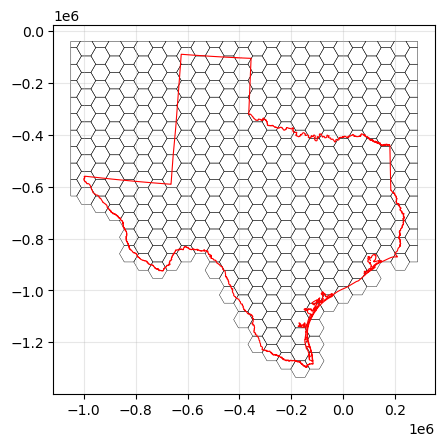

In [40]:
# 局部放大：以美国疆域为基础，缩小bbox尺寸 (如Texas)

us_states_proj = us_states.to_crs("ESRI:102003")
state_name = "Texas"
texas_geom = us_states_proj[us_states_proj["NAME"] == state_name].geometry.iloc[0]

# 生成更小bbox（可适当buffer扩大一点视野范围）
texas_bbox = texas_geom.bounds
buffer_m = 50000  # 例如，四周各扩展50公里
minx, miny, maxx, maxy = texas_bbox
texas_bbox_polygon = box(minx-buffer_m, miny-buffer_m, maxx+buffer_m, maxy+buffer_m)

# 投影hex到相同坐标系
hex_proj = hex_gdf_full_3500.to_crs("ESRI:102003")

# 按texas_bbox裁剪
hex_clipped = gpd.clip(hex_proj, texas_bbox_polygon)

# 可视化
ax = hex_clipped.plot(edgecolor="k", facecolor="none", linewidth=0.3)
gpd.GeoSeries(texas_geom).boundary.plot(ax=ax, color="red", linewidth=0.8)


## Module 2: GMM Scoring and Cluster Assignment


In [66]:
from function import *
import geopandas as gpd
from function.gmm_training import CombinedPreprocessor 
from shapely.geometry import Polygon, Point, box
import joblib
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pyproj import Transformer
import geopandas as gpd
import h3

# hex_gdf_h4 = gpd.read_file("data/US_data/hex_gdf_H4.geojson")
# hex_gdf_h4 = gpd.read_file("data/US_data/hex_gdf_H3.geojson")
# hex_gdf_h4 = gpd.read_file('data/US_data/hex_gdf_2500.geojson')
# hex_gdf_h4 = gpd.read_file('data/US_data/hex_gdf_3500.geojson')
# hex_gdf_h4 = gpd.read_file('data/US_data/hex_gdf_4000.geojson')
hex_gdf_h4 = gpd.read_file('data/US_data/hex_gdf_4500.geojson')


gmm_pipeline = joblib.load('gmm_model_23c_fixed.pkl')
# Load US shapefiles
us_nation = gpd.read_file(r'data\US_data\cb_2018_us_nation_5m.shp')
us_states = gpd.read_file(r'data\cb_2018_us_state_500k.shp')


In [67]:
import joblib
import numpy as np
from scipy.cluster.hierarchy import linkage, fcluster
from scipy.spatial.distance import pdist
import geopandas as gpd
from shapely.geometry import Point



def calculate_cluster_probabilities(hex_gdf, gmm_pipeline, distance_threshold=1.5):
    """
    Calculate cluster probabilities using dynamic hierarchical clustering.

    """
    print("\n=== Calculating Cluster Probabilities ===")
    
    preprocessor = gmm_pipeline.named_steps['preprocessor']
    gmm = gmm_pipeline.named_steps['gmm']
    means = gmm.means_
    n_components = gmm.n_components
    
    # 动态层次聚类
    numeric_features = preprocessor.numeric_features
    categorical_features = preprocessor.categorical_features
    n_numeric = len(numeric_features)
    
    print(f"模型特征信息：")
    print(f"  Numeric features: {numeric_features}")
    print(f"  Categorical features: {categorical_features}")
    
    if categorical_features:
        landcover_means = means[:, n_numeric:]
        dominant_landcover_values = np.take_along_axis(
            landcover_means, 
            np.argmax(landcover_means, axis=1)[:, np.newaxis], 
            axis=1
        ).squeeze()
        component_features_std = np.column_stack([
            means[:, :n_numeric], 
            dominant_landcover_values[:, np.newaxis]
        ])
    else:
        component_features_std = means
    
    distance_matrix = pdist(component_features_std, metric='correlation')
    linkage_matrix = linkage(distance_matrix, method='ward')
    cluster_labels = fcluster(linkage_matrix, t=distance_threshold, criterion='distance')
    
    # 构建动态映射
    clusters_dict = {}
    for comp_idx in range(n_components):
        cluster_id = cluster_labels[comp_idx]
        if cluster_id not in clusters_dict:
            clusters_dict[cluster_id] = []
        clusters_dict[cluster_id].append(comp_idx)
    
    print(f"\n动态生成的聚类映射:")
    for cluster_id, components in clusters_dict.items():
        print(f"  Cluster {cluster_id}: Components {components}")
    
    # 关键：按照模型期望的features顺序排列列
    features_in_order = numeric_features + categorical_features
    
    # 数据质量检查
    print(f"\n=== 数据质量检查 ===")
    print(f"六边形数据统计（前5个特征）:")
    for feat in features_in_order[:5]:
        if feat in hex_gdf.columns:
            col_data = hex_gdf[feat]
            print(f"  {feat}: "
                  f"min={col_data.min():.2f}, "
                  f"max={col_data.max():.2f}, "
                  f"mean={col_data.mean():.2f}, "
                  f"NaN={col_data.isna().sum()}")
    
    # 检查缺失值
    data_for_transformation = hex_gdf[features_in_order]
    missing_counts = data_for_transformation.isnull().sum()
    if missing_counts.sum() > 0:
        print(f"\n⚠️ 发现缺失值:")
        for col in missing_counts[missing_counts > 0].index:
            print(f"  {col}: {missing_counts[col]} 缺失")
    
    # 检查无穷值
    inf_counts = np.isinf(data_for_transformation[numeric_features]).sum()
    if inf_counts.sum() > 0:
        print(f"\n⚠️ 发现无穷值:")
        for col in inf_counts[inf_counts > 0].index:
            print(f"  {col}: {inf_counts[col]} 无穷值")
    
    X_transformed = preprocessor.transform(hex_gdf[features_in_order])
    component_probs = gmm.predict_proba(X_transformed)
    
    print(f"\nComponent probabilities shape: {component_probs.shape}")
    
    # 详细统计各component的概率
    print("\n=== Component Probability Statistics ===")
    comp_means = component_probs.mean(axis=0)
    comp_max = component_probs.max(axis=0)
    comp_min = component_probs.min(axis=0)
    comp_dominant_counts = (np.argmax(component_probs, axis=1).reshape(-1,1) == np.arange(n_components)).sum(axis=0)

    component_columns = [f"component_{i}" for i in range(n_components)]
    component_prob_df = pd.DataFrame(component_probs, columns=component_columns, index=hex_gdf.index)

    
    # 显示前10个和后10个component的统计
    print("Top 10 components by average probability:")
    top_comps = np.argsort(comp_means)[-10:][::-1]
    for comp_idx in top_comps:
        if comp_means[comp_idx] > 0:
            print(f"Component {comp_idx}: mean={comp_means[comp_idx]:.4f}, "
                  f"max={comp_max[comp_idx]:.4f}, "
                  f"min={comp_min[comp_idx]:.4f}, "
                  f"dominant={comp_dominant_counts[comp_idx]}")
    
    n_hexagons = len(hex_gdf)
    
    # 聚合到cluster概率
    n_clusters = len(clusters_dict)
    cluster_probs = np.zeros((n_hexagons, n_clusters))
    
    for cluster_idx, components in enumerate(clusters_dict.values()):
        cluster_probs[:, cluster_idx] = component_probs[:, components].sum(axis=1)

        
    cluster_columns = [f"cluster_{cid}" for cid in clusters_dict.keys()]
    cluster_prob_df = pd.DataFrame(cluster_probs, columns=cluster_columns, index=hex_gdf.index)
    
    # Cluster概率统计
    print(f"\n=== Cluster Probability Statistics ===")
    print(f"Cluster probabilities shape: {cluster_probs.shape}")
    
    for cluster_idx in range(n_clusters):
        cluster_id = list(clusters_dict.keys())[cluster_idx]
        mean_prob = cluster_probs[:, cluster_idx].mean()
        max_prob = cluster_probs[:, cluster_idx].max()
        min_prob = cluster_probs[:, cluster_idx].min()
        print(f"Cluster {cluster_id}: mean={mean_prob:.3f}, max={max_prob:.3f}, min={min_prob:.3f}")
    
    # 统计dominant cluster分布
    dominant_clusters = cluster_probs.argmax(axis=1)
    for cluster_idx in range(n_clusters):
        cluster_id = list(clusters_dict.keys())[cluster_idx]
        count = (dominant_clusters == cluster_idx).sum()
        pct = 100 * count / n_hexagons
        print(f"Cluster {cluster_id}: {count} hexagons ({pct:.1f}%)")


    
    return cluster_probs,component_prob_df,cluster_prob_df


# Calculate cluster probabilities
cluster_probs, component_prob_df,cluster_prob_df= calculate_cluster_probabilities(hex_gdf_h4, gmm_pipeline)
hex_gdf_h4['component_probs'] = list(component_prob_df.values.tolist())
hex_gdf_h4['cluster_probs'] = list(cluster_prob_df.values.tolist())
hex_gdf_h4['dominant_cluster'] = cluster_probs.argmax(axis=1)


=== Calculating Cluster Probabilities ===
模型特征信息：
  Numeric features: ['GDPpc', 'GDPtot', 'Population', 'Powerdist', 'DEM', 'Slope', 'GURdist', 'PrimaryRoad', 'SecondaryRoad', 'TertiaryRoad', 'tas', 'gdmp', 'rsds', 'wind']
  Categorical features: ['landcover']

动态生成的聚类映射:
  Cluster 3: Components [0, 5, 6, 12, 14, 18, 22]
  Cluster 1: Components [1, 4, 7, 10, 13, 15, 17]
  Cluster 2: Components [2, 3, 8, 9, 11, 16, 19, 20, 21]

=== 数据质量检查 ===
六边形数据统计（前5个特征）:
  GDPpc: min=21802.00, max=136851.00, mean=51775.51, NaN=0
  GDPtot: min=0.00, max=132888676.00, mean=1971088.79, NaN=0
  Population: min=0.00, max=2343.15, mean=24.34, NaN=0
  Powerdist: min=782.83, max=3635954.60, mean=20201.70, NaN=0
  DEM: min=13.41, max=2804.15, mean=773.75, NaN=0

Component probabilities shape: (1911, 23)

=== Component Probability Statistics ===
Top 10 components by average probability:
Component 20: mean=0.2199, max=1.0000, min=0.0000, dominant=425
Component 12: mean=0.1600, max=1.0000, min=0.0000, dominant

In [70]:
def calculate_hex_pattern_contributions(hex_gdf, gmm_pipeline, component_probs):
    """
    基于 GMM component 特征权重（|均值| × sqrt(方差) × component weight）
    + 每个 hex 对 component 的责任度（component_probs）来计算四大 pattern 的贡献。
    """
    print("\n=== Calculating Feature Group Patterns (GMM-aligned) ===")

    preprocessor = gmm_pipeline.named_steps['preprocessor']
    gmm = gmm_pipeline.named_steps['gmm']

    numeric_features = preprocessor.numeric_features
    categorical_features = preprocessor.categorical_features
    all_features = numeric_features + categorical_features
    n_numeric = len(numeric_features)

    means = gmm.means_
    weights = gmm.weights_
    covariances = gmm.covariances_
    n_components = gmm.n_components

    if gmm.covariance_type == 'full':
        variances = np.array([np.diag(covariances[k]) for k in range(n_components)])
    elif gmm.covariance_type == 'diag':
        variances = covariances
    else:
        variances = np.ones_like(means)

    if categorical_features:
        landcover_means = means[:, n_numeric:]
        landcover_variances = variances[:, n_numeric:]
        dominant_landcover_values = np.take_along_axis(
            landcover_means,
            np.argmax(landcover_means, axis=1)[:, np.newaxis],
            axis=1
        ).squeeze()
        component_features_std = np.column_stack([
            means[:, :n_numeric],
            dominant_landcover_values[:, np.newaxis],
        ])
        variances_for_display = np.column_stack([
            variances[:, :n_numeric],
            landcover_variances.mean(axis=1, keepdims=True),
        ])
        n_landcover_cats = landcover_means.shape[1]
    else:
        landcover_means = None
        landcover_variances = None
        component_features_std = means
        variances_for_display = variances

    feature_groups = {
        'Socioeconomic': ['Population', 'GDPpc', 'GDPtot', 'GURdist'],
        'Infrastructure': ['Powerdist', 'PrimaryRoad', 'SecondaryRoad', 'TertiaryRoad'],
        'Geographic': ['DEM', 'Slope', 'gdmp'],
        'Climatic': ['rsds', 'tas', 'wind'],
    }
    landcover_to_pattern = {
        1: ['Socioeconomic'], 2: ['Geographic'], 3: ['Geographic'],
        4: ['Geographic'], 5: ['Geographic'], 6: ['Climatic'],
        7: ['Socioeconomic', 'Infrastructure'], 8: ['Geographic'], 9: ['Climatic'],
    }

    def component_pattern_scores(comp_idx: int):
        scores = {name: 0.0 for name in feature_groups.keys()}

        for pattern_name, feats in feature_groups.items():
            idxs = [all_features.index(f) for f in feats if f in all_features]
            if idxs:
                scores[pattern_name] += (
                    np.abs(component_features_std[comp_idx, idxs]) *
                    np.sqrt(variances_for_display[comp_idx, idxs]) *
                    weights[comp_idx]
                ).sum()

        if landcover_means is not None:
            for lc_idx in range(n_landcover_cats):
                lc_class = lc_idx + 1
                if lc_class in landcover_to_pattern:
                    patterns = landcover_to_pattern[lc_class]
                    lc_contrib = (
                        np.abs(landcover_means[comp_idx, lc_idx]) *
                        np.sqrt(landcover_variances[comp_idx, lc_idx]) *
                        weights[comp_idx]
                    )
                    share = lc_contrib / len(patterns)
                    for pattern in patterns:
                        scores[pattern] += share

        total = sum(scores.values())
        if total > 1e-12:
            return {k: v / total for k, v in scores.items()}
        return {k: 0.25 for k in scores.keys()}

    component_pattern_matrix = np.array([
        list(component_pattern_scores(k).values())
        for k in range(n_components)
    ])
    pattern_labels = list(feature_groups.keys())

    if component_probs.shape[1] != n_components:
        raise ValueError("component_probs 列数必须等于 GMM component 数量")

    hex_pattern_scores = component_probs @ component_pattern_matrix
    row_sums = hex_pattern_scores.sum(axis=1, keepdims=True)
    row_sums[row_sums == 0] = 1.0
    hex_pattern_shares = hex_pattern_scores / row_sums

    pattern_share_df = pd.DataFrame(
        hex_pattern_shares,
        columns=pattern_labels,
        index=hex_gdf.index
    )

    pattern_weights = []
    for row_vals in hex_pattern_shares:
        sorted_pairs = sorted(
            zip(pattern_labels, row_vals),
            key=lambda x: x[1],
            reverse=True
        )
        pattern_weights.append({
            'groups': [g for g, _ in sorted_pairs[:3]],
            'weights': [w for _, w in sorted_pairs[:3]],
        })

    print(f"Pattern weights calculated for {len(pattern_weights)} hexagons (GMM-aligned)")

    totals = pd.Series(hex_pattern_shares.sum(axis=0), index=pattern_labels)
    print("\nFeature group dominance statistics (GMM-aligned):")
    for name, total_weight in totals.sort_values(ascending=False).items():
        pct = 100 * total_weight / len(hex_gdf)
        print(f"  {name}: {total_weight:.2f} ({pct:.1f}% average contribution)")

    return pattern_weights, pattern_share_df


pattern_weights, pattern_share_df = calculate_hex_pattern_contributions(
    hex_gdf_h4, gmm_pipeline, component_prob_df.values
)
for pattern_name in pattern_share_df.columns:
    hex_gdf_h4[f'pattern_{pattern_name}_share'] = pattern_share_df[pattern_name]


=== Calculating Feature Group Patterns (GMM-aligned) ===
Pattern weights calculated for 1911 hexagons (GMM-aligned)

Feature group dominance statistics (GMM-aligned):
  Geographic: 676.55 (35.4% average contribution)
  Climatic: 478.07 (25.0% average contribution)
  Infrastructure: 406.52 (21.3% average contribution)
  Socioeconomic: 349.85 (18.3% average contribution)


In [71]:
pattern_share_df 

,Socioeconomic,Infrastructure,Geographic,Climatic
0,0.304179,0.339593,0.323923,0.032306
1,0.080466,0.055627,0.688639,0.175268
2,0.080466,0.055627,0.688639,0.175268
3,0.080466,0.055627,0.688639,0.175268
4,0.304179,0.339593,0.323923,0.032306
...,...,...,...,...
1906,0.080464,0.055639,0.688617,0.175280
1907,0.142622,0.231651,0.319093,0.306633
1908,0.304179,0.339593,0.323923,0.032306
1909,0.229782,0.598389,0.145365,0.026464


## Module 3: Hexagonal Map Visualization


### relevant data for plot

这里的设计难点在于各个hex的坐标转换与算力开销

主要数据输入：
df_embedding_fill
df_analysis
hex_gdf_h4 （必须匹配了各个hex内部的pattern contribution与dominant cluster）
us的有关矢量边界

Legend 模块：


根据生成的各个dominant cluster 分配圆心相应的圆形颜色
根据生成的各个pattern_{}_share 分配外围圆形相应的原色




图形设置
PV site 散点模块：
绘制df_embedding_fill的散点


Cluster 圆形模块：
在圆心创建一个circle对象
center x =hex center x
center y =hex center y
r=1/4的hex边长

if df_analysis[lat] & [lon] within hex: 
    创建对应的circle 并且绘制dominant id 对应的颜色
    else 所有的cluster circle == 灰色


Feature Pattern 进度模块：
for each hex：
    for pattern in enumerate(patter_groups):
        if one of the pattern in hex_gdf_4 >= 0.25（意思是大于25%的贡献）
            在距离cluster center 直线距离=2r的不同位置绘制半径为3/4r的pattern circle
            位置以下情况
          
pattern_Socioeconomic_share>0.25: (center x+ 2r,0) '#f6c96c',  # 浅橙色
pattern_Infrastructure_share> 0.25 : (0,center y+ 2r) '#8fd2f1',  # 浅蓝色
pattern_Geographic_share	> 0.25 : (center x - 2r,0) '#33d6a5',     # 浅绿色
pattern_Climatic_share		> 0.25 : (0,center y - 2r) '#e9834c',       # 浅红棕色

In [58]:
''' 
这里需要载入的核心是叠加PV sites和识别出具有abandoned sites的地点
'''
from function import *
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point



def clip_data_with_us_states(df, us_states_gdf, lon_col='lon', lat_col='lat'):
    """
    使用美国州界 shapefile 剪裁点数据；兼容不同版本的 geopandas 参数名
    """
    geometry = [Point(xy) for xy in zip(df[lon_col], df[lat_col])]
    gdf = gpd.GeoDataFrame(df, geometry=geometry, crs='EPSG:4326')
    us_states_4326 = us_states_gdf.to_crs('EPSG:4326')

    try:
        clipped = gpd.sjoin(gdf, us_states_4326, how='inner', predicate='within')
    except TypeError:
        # 旧版本 geopandas 使用 op 参数
        clipped = gpd.sjoin(gdf, us_states_4326, how='inner', op='within')

    # 清理 shapefile 附加字段
    clipped = clipped.drop(columns=['geometry', 'index_right'], errors='ignore')
    for col in us_states_gdf.columns:
        if col in clipped.columns:
            clipped = clipped.drop(columns=[col], errors='ignore')
    return clipped



# ---------------------------
# 0) 基础地理范围与底图
# ---------------------------
usa_bounds_main = dict(lon_min=-125, lon_max=-65, lat_min=25, lat_max=49)
us_nation = gpd.read_file(r'data\US_data\cb_2018_us_nation_5m.shp')

# ---------------------------
# 1) 读取数据
# ---------------------------
df_embedding = load_embedding(PATHS['us_pv_embedding'])

# 初步经纬度范围过滤
df_embedding = df_embedding[
    (df_embedding['lon'] >= usa_bounds_main['lon_min']) &
    (df_embedding['lon'] <= usa_bounds_main['lon_max']) &
    (df_embedding['lat'] >= usa_bounds_main['lat_min']) &
    (df_embedding['lat'] <= usa_bounds_main['lat_max'])
]

# 第二次用州界矢量更精确裁剪
df_embedding = clip_data_with_us_states(df_embedding, us_nation)

# ---------------------------
# 2) 缺失值填充 + 去重
# ---------------------------
df_embedding_fill = fill_nonpositive_with_nearest(df_embedding)


# ---------------------------
# 3) 特征选择（排除经纬度）
# ---------------------------
features_no_coords = [f for f in (NUMERIC_FEATURES + CAT_COLS) if f not in ['lat', 'lon']]
# 只保留在 df_embedding_fill 列中实际存在的特征（防止有些特征名在数据中不存）
features_no_coords = [c for c in features_no_coords if c in df_embedding_fill.columns]

    
df_analysis=pd.read_csv(r'data\US_data\df_merged_data_for_analysis.csv')
df_analysis

列 GDPpc 没有需要填充的非正值或NaN值


,lat,lon,predicted_prob,gmm_density,sample_type,LNCS_expect,net_npv_usd,area_m2,E_yr_pixel,pv_potential_dens,power_generation_kwha,Expectation_net_benefit,ccd_optimized
0,25.295834,-80.287500,0.902568,2.806133e+19,prediction,811.854595,411724.028993,776295.361002,1.958127e+08,5568.344207,7.567199e+07,4756.489612,0.940305
1,25.437500,-80.537500,0.997976,5.399806e+21,prediction,1348.189022,287052.220262,775385.854124,1.913273e+08,5447.174926,7.402534e+07,4098.985904,0.828012
2,25.437500,-80.495834,0.995833,1.508036e+20,prediction,971.186274,278019.855286,775385.854124,1.910215e+08,5438.469092,7.390703e+07,4467.282818,0.882208
3,25.445833,-80.454170,0.990886,1.800785e+16,prediction,972.811005,272893.696918,775332.207938,1.908320e+08,5433.449375,7.383881e+07,4460.638370,0.880366
4,25.445833,-80.404170,0.996591,6.792866e+22,prediction,968.544647,294800.434504,775332.207938,1.915894e+08,5455.012162,7.413184e+07,4486.467516,0.888518
...,...,...,...,...,...,...,...,...,...,...,...,...,...
70332,48.995834,-99.995834,0.914557,5.692829e+14,prediction,377.830800,-556486.868714,563356.382622,1.180457e+08,4625.717362,6.286200e+07,4247.886562,0.790359
70333,48.995834,-99.987500,0.921603,1.413612e+14,prediction,307.516600,-562376.609379,563356.382622,1.178997e+08,4619.997412,6.278426e+07,4312.480812,0.800732
70334,48.995834,-99.895836,0.872176,3.161397e+13,prediction,324.674320,-598319.346882,563356.382622,1.170071e+08,4585.017928,6.230891e+07,4260.343608,0.757385
70335,48.995834,-99.887500,0.799749,6.767585e+13,prediction,323.374660,-594934.043507,563356.382622,1.170906e+08,4588.290785,6.235338e+07,4264.916125,0.691242


In [59]:
df_embedding_fill

,time,lat,lon,abandonment_year,unique_id,p_area,capacity_m,country,year,abandonment_duration,...,landcover_at_abandonment,Population,Powerdist,PrimaryRoad,rsds,SecondaryRoad,Slope,tas,TertiaryRoad,wind
217,2018-01-01,25.787500,-80.387500,1995.0,34469,3413.769589,0.331533,USA,2018,28.0,...,NaN,0.288029,0.00000,239.976668,17.709135,124.925079,0.188917,2979.915296,1819.419167,2.362765
218,2018-01-01,25.795834,-80.387500,NaN,34519,1783.635896,0.173283,USA,2018,NaN,...,NaN,0.288029,780.78986,239.976668,17.692776,124.925079,0.415473,2979.836073,1819.419167,2.547076
221,2018-01-01,26.112500,-98.020836,NaN,33917,11585.736350,1.048494,USA,2018,NaN,...,NaN,5.687756,780.78986,20.141565,17.591680,9.576520,0.192031,2970.665273,312.681172,4.070180
222,2018-01-01,26.145834,-97.837500,NaN,34012,3746.567969,0.366137,USA,2018,NaN,...,NaN,192.709230,1561.57970,17.949732,17.417795,21.429836,0.165108,2970.248631,203.554745,4.393748
223,2018-01-01,26.145834,-97.829170,1999.0,33985,3880.401559,0.379216,USA,2018,24.0,...,NaN,1551.475000,780.78986,17.949732,17.413290,21.429836,0.259286,2970.168037,203.554745,4.142279
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25881,2020-01-01,44.804165,-69.837500,NaN,11877,82831.923240,4.949656,USA,2020,NaN,...,NaN,48.138603,780.78986,14.078793,13.552799,17.696589,2.629778,2793.727888,112.898732,2.632521
25960,2020-01-01,45.104168,-70.812500,NaN,11950,341.959494,0.000000,USA,2020,NaN,...,NaN,47.884193,12614.04600,14.078793,13.883422,17.696589,15.683168,2750.094433,38.658111,5.387349
26040,2020-01-01,45.462500,-69.312500,NaN,20684,135.812527,0.000000,USA,2020,NaN,...,NaN,11.710216,14397.05400,19.567633,12.888320,9.992456,2.185234,2775.382529,12.537485,2.217898
26049,2020-01-01,45.520832,-69.354164,NaN,20588,67.717411,0.000000,USA,2020,NaN,...,NaN,11.710216,14998.48400,19.567633,13.214517,9.992456,3.558586,2773.277881,12.537485,2.474060







Lenged 逻辑：

创建一个六边形，边长为figsize xmax-xmin 的0.1倍（绝对坐标），边长记录为hex_radius_abs
在六边形内部，参照cluster与feature的绘制逻辑，

首先在center绘制一个cluster circle

其次在cluster 周围绘制 四个patter circle

        'Socioeconomic': '#e09e21',   # 深金色
        'Infrastructure': '#224183',  # 深蓝色
        'Geographic': '#229d6e',      # 深绿色
        'Climatic': '#a34618',        # 深橙棕色
        
cluster_base_r_abs = hex_radius_abs * 0.2
pattern_r_abs = base_r_abs * 1.5
绘制的相应位置参照plot_hexagonal_gmm_map函数与offsets设置
pattern_circles.append({'xy': (x_pat, y_pat), 'area_pts2': area_pat_pts2,
                                        'c': pattern_colors.get(pname, '#808080')})



加入曲线经纬网格模块

def _draw_graticule_top_labels(ax, lon_ticks, lat_ticks, usa_bounds_main, proj_fwd, proj_inv):
    """绘制经纬度网格，标签显示在上方和右方（曲线网格）"""
    def extent_lonlat_from_axes(ax, pad_deg=3):
        xmin, xmax = ax.get_xlim(); ymin, ymax = ax.get_ylim()
        xs = np.linspace(xmin, xmax, 512)
        ys = np.linspace(ymin, ymax, 512)
        
        b_lon, b_lat = proj_inv.transform(xs, np.full_like(xs, ymin))
        t_lon, t_lat = proj_inv.transform(xs, np.full_like(xs, ymax))
        l_lon, l_lat = proj_inv.transform(np.full_like(ys, xmin), ys)
        r_lon, r_lat = proj_inv.transform(np.full_like(ys, xmax), ys)
        
        lon_min = np.nanmin([b_lon.min(), t_lon.min(), l_lon.min(), r_lon.min()]) - pad_deg
        lon_max = np.nanmax([b_lon.max(), t_lon.max(), l_lon.max(), r_lon.max()]) + pad_deg
        lat_min = np.nanmin([b_lat.min(), t_lat.min(), l_lat.min(), r_lat.min()]) - pad_deg
        lat_max = np.nanmax([b_lat.max(), t_lat.max(), l_lat.max(), r_lat.max()]) + pad_deg
        
        return (lon_min, lon_max), (lat_min, lat_max)

    def _project_xy(xy):
        xs, ys = proj_fwd.transform(xy[:,0], xy[:,1])
        return np.column_stack([xs, ys])

    # 轴框与四边
    xmin, xmax = ax.get_xlim(); ymin, ymax = ax.get_ylim()
    frame = box(xmin, ymin, xmax, ymax)

    # 获取经纬度范围
    lon_ext, lat_ext = extent_lonlat_from_axes(ax, pad_deg=3)

    # 经度刻度和网格线（曲线）
    xticks = []
    for i, lon in enumerate(lon_ticks):
        lats = np.linspace(lat_ext[0], lat_ext[1], 1000)
        xy = _project_xy(np.column_stack([np.full_like(lats, lon), lats]))
        line = LineString(xy)

        # 只绘制地图内的曲线网格线，裁剪到地图区域
        clip_line = line.intersection(frame)
        if not clip_line.is_empty and clip_line.geom_type == 'LineString':
            coords = list(clip_line.coords)
            if len(coords) > 1:
                coords_array = np.array(coords)
                ax.plot(coords_array[:,0], coords_array[:,1], lw=0.3, color="#cfcfcf", zorder=0.6, alpha=0.7)

        # 只在顶部边界寻找交点
        top_edge = LineString([(xmin, ymax), (xmax, ymax)])
        intersection = line.intersection(top_edge)
        
        if not intersection.is_empty:
            if intersection.geom_type == 'Point':
                xticks.append(intersection.x)
                ax.text(intersection.x, ymax + (ymax - ymin) * 0.02, f"{abs(int(round(lon)))}°W",
                       ha='center', va='bottom', fontsize=5, zorder=20, color='#666666',
                       bbox=dict(boxstyle='round,pad=0.2', facecolor='white', alpha=0.7, 
                               edgecolor='none'))
            elif intersection.geom_type == 'MultiPoint':
                # 如果交点有多个，选择最左侧的
                points = list(intersection.geoms)
                if points:
                    x_coords = [p.x for p in points]
                    min_x_idx = np.argmin(x_coords)
                    xticks.append(points[min_x_idx].x)
                    ax.text(points[min_x_idx].x, ymax + (ymax - ymin) * 0.02, f"{abs(int(round(lon)))}°W",
                           ha='center', va='bottom', fontsize=5, zorder=20, color='#666666',
                           bbox=dict(boxstyle='round,pad=0.2', facecolor='white', alpha=0.7, 
                                   edgecolor='none'))

    # 纬度刻度和网格线（曲线）
    yticks = []
    for lat in lat_ticks:
        lons = np.linspace(lon_ext[0], lon_ext[1], 1000)
        xy = _project_xy(np.column_stack([lons, np.full_like(lons, lat)]))
        line = LineString(xy)

        # 只绘制地图内的曲线网格线
        clip_line = line.intersection(frame)
        if not clip_line.is_empty and clip_line.geom_type == 'LineString':
            coords = list(clip_line.coords)
            if len(coords) > 1:
                coords_array = np.array(coords)
                ax.plot(coords_array[:,0], coords_array[:,1], lw=0.3, color="#cfcfcf", zorder=0.6, alpha=0.7)

        # 只在左侧边界寻找交点
        left_edge = LineString([(xmin, ymin), (xmin, ymax)])
        intersection = line.intersection(left_edge)
        
        if not intersection.is_empty:
            if intersection.geom_type == 'Point':
                yticks.append(intersection.y)
                ax.text(xmin - (xmax - xmin) * 0.02, intersection.y, f"{int(round(lat))}°N",
                       ha='right', va='center', fontsize=5, zorder=20, color='#666666',
                       bbox=dict(boxstyle='round,pad=0.2', facecolor='white', alpha=0.7,
                               edgecolor='none'))
            elif intersection.geom_type == 'MultiPoint':
                # 如果交点有多个，选择中间的
                points = list(intersection.geoms)
                if points:
                    mid_idx = len(points) // 2
                    yticks.append(points[mid_idx].y)
                    ax.text(xmin - (xmax - xmin) * 0.02, points[mid_idx].y, f"{int(round(lat))}°N",
                           ha='right', va='center', fontsize=5, zorder=20, color='#666666',
                           bbox=dict(boxstyle='round,pad=0.2', facecolor='white', alpha=0.7,
                                   edgecolor='none'))
    """绘制经纬度网格，标签显示在上方和左侧（曲线网格，去除右侧标签）"""
    def extent_lonlat_from_axes(ax, pad_deg=3):
        xmin, xmax = ax.get_xlim(); ymin, ymax = ax.get_ylim()
        xs = np.linspace(xmin, xmax, 512)
        ys = np.linspace(ymin, ymax, 512)
        
        b_lon, b_lat = proj_inv.transform(xs, np.full_like(xs, ymin))
        t_lon, t_lat = proj_inv.transform(xs, np.full_like(xs, ymax))
        l_lon, l_lat = proj_inv.transform(np.full_like(ys, xmin), ys)
        r_lon, r_lat = proj_inv.transform(np.full_like(ys, xmax), ys)
        
        lon_min = np.nanmin([b_lon.min(), t_lon.min(), l_lon.min(), r_lon.min()]) - pad_deg
        lon_max = np.nanmax([b_lon.max(), t_lon.max(), l_lon.max(), r_lon.max()]) + pad_deg
        lat_min = np.nanmin([b_lat.min(), t_lat.min(), l_lat.min(), r_lat.min()]) - pad_deg
        lat_max = np.nanmax([b_lat.max(), t_lat.max(), l_lat.max(), r_lat.max()]) + pad_deg
        
        return (lon_min, lon_max), (lat_min, lat_max)

    def _project_xy(xy):
        xs, ys = proj_fwd.transform(xy[:,0], xy[:,1])
        return np.column_stack([xs, ys])

    def _choose_point_on_edge(geom):
        if geom.is_empty:
            return None
        if geom.geom_type == "Point":
            return geom
        if geom.geom_type.startswith("Multi") or geom.geom_type == "GeometryCollection":
            pts = [g for g in getattr(geom, "geoms", []) if g.geom_type == "Point"]
            return pts[0] if pts else None
        if geom.geom_type == "LineString":
            return geom.interpolate(0.5, normalized=True)
        return None

    # 轴框与四边
    xmin, xmax = ax.get_xlim(); ymin, ymax = ax.get_ylim()
    frame = box(xmin, ymin, xmax, ymax)
    left = LineString([(xmin, ymin), (xmin, ymax)])
    right = LineString([(xmax, ymin), (xmax, ymax)])  
    bottom = LineString([(xmin, ymin), (xmax, ymin)])
    top = LineString([(xmin, ymax), (xmax, ymax)])

    # 获取经纬度范围
    lon_ext, lat_ext = extent_lonlat_from_axes(ax, pad_deg=3)

    # 经度刻度和网格线（曲线）
    xticks = []
    for i, lon in enumerate(lon_ticks):
        lats = np.linspace(lat_ext[0], lat_ext[1], 1000)
        xy = _project_xy(np.column_stack([np.full_like(lats, lon), lats]))
        line = LineString(xy)

        # 绘制曲线网格线
        ax.plot(xy[:,0], xy[:,1], lw=0.3, color="#cfcfcf", zorder=0.6, alpha=0.7)

        # 在顶部显示标签
        p = _choose_point_on_edge(line.intersection(top))
        if p is None:
            p = _choose_point_on_edge(line.intersection(bottom))
        if p is not None:
            # 检查与已有标签的最小距离
            min_distance = 0.02 * (ax.get_xlim()[1] - ax.get_xlim()[0])
            if not xticks or min([abs(p.x - x) for x in xticks]) > min_distance:
                xticks.append(p.x)
                # 在上方显示标签
                ax.text(p.x, ymax + (ymax - ymin) * 0.02, f"{abs(int(round(lon)))}°W",
                       ha='center', va='bottom', fontsize=5, zorder=20, color='#666666',
                       bbox=dict(boxstyle='round,pad=0.2', facecolor='white', alpha=0.7, 
                               edgecolor='none'))

    # 纬度刻度和网格线（曲线）
    yticks = []
    for lat in lat_ticks:
        lons = np.linspace(lon_ext[0], lon_ext[1], 1000)
        xy = _project_xy(np.column_stack([lons, np.full_like(lons, lat)]))
        line = LineString(xy)

        # 绘制曲线网格线
        ax.plot(xy[:,0], xy[:,1], lw=0.3, color="#cfcfcf", zorder=0.6, alpha=0.7)

        # 只在左侧显示标签（不在右侧）
        p = _choose_point_on_edge(line.intersection(left))
        if p is not None:
            yticks.append(p.y)
            ax.text(xmin - (xmax - xmin) * 0.02, p.y, f"{int(round(lat))}°N",
                   ha='right', va='center', fontsize=5, zorder=20, color='#666666',
                   bbox=dict(boxstyle='round,pad=0.2', facecolor='white', alpha=0.7,
                           edgecolor='none'))

In [60]:
def add_legend_panel(fig, cluster_colors, pattern_colors, unique_clusters, 
                     legend_bbox=[0.02, 0.02, 0.28, 0.38]):
    """
    单独封装图例函数：绘制六边形、cluster circle、pattern circles、光晕和经纬网格
    
    Parameters
    ----------
    fig : matplotlib figure
    cluster_colors : dict，cluster ID到颜色的映射
    pattern_colors : dict，pattern名称到颜色的映射
    unique_clusters : list，唯一的cluster ID列表
    legend_bbox : list，[x, y, width, height] in figure coordinates
    
    Returns
    -------
    legend_ax : matplotlib axis
    """
    from shapely.geometry import Polygon, Point, LineString
    from shapely.ops import unary_union
    import geopandas as gpd
    import numpy as np
    
    # 创建图例坐标轴
    legend_ax = fig.add_axes(legend_bbox)
    legend_ax.set_facecolor('white')
    legend_ax.set_alpha(0.92)
    legend_ax.axis('off')
    
    # 使用绝对坐标范围：0-1
    xmin, ymin, xmax, ymax = 0.0, 0.0, 1.0, 1.0
    width = xmax - xmin  # = 1.0
    
    # ========== 创建六边形 ==========
    # 六边形边长（绝对坐标）
    hex_radius_abs = width * 0.1  # 边长为宽度的10%
    
    # 六边形中心位置（居中偏下）
    hex_center_x = 0.5
    hex_center_y = 0.35
    
    # 创建正六边形的六个顶点（平顶六边形）
    hex_vertices = []
    for i in range(6):
        angle = np.pi / 3 * i - np.pi / 6  # 从顶部开始，逆时针
        x = hex_center_x + hex_radius_abs * np.cos(angle)
        y = hex_center_y + hex_radius_abs * np.sin(angle)
        hex_vertices.append((x, y))
    
    # 创建完整的六边形
    hex_poly = Polygon(hex_vertices)
    
    # ========== 绘制六边形外围光晕 ==========
    # 参照 _draw_glow_outline_outside 的逻辑
    # 在绝对坐标下，使用相对半径
    glow_radii_rel = [0.005, 0.008, 0.012]  # 相对半径（对应 0.5%, 0.8%, 1.2%）
    glow_alphas = (0.95, 0.5, 0.3)
    glow_colors = ("#08336e", "#105ca4", "#3888c0")
    
    last_inner = hex_poly.buffer(0)
    for i, (r_rel, alpha, color) in enumerate(zip(glow_radii_rel, glow_alphas, glow_colors)):
        outer = hex_poly.buffer(r_rel, join_style=2, cap_style=2)
        ring = outer.difference(last_inner)
        if not ring.is_empty:
            gpd.GeoSeries([ring], crs='EPSG:4326').plot(
                ax=legend_ax, color=color, alpha=alpha, edgecolor="none", zorder=1 + i*0.01
            )
        last_inner = outer
    
    # 绘制六边形边框
    gpd.GeoSeries([hex_poly], crs='EPSG:4326').plot(
        ax=legend_ax, color='none', edgecolor='#444444', linewidth=0.8, zorder=5
    )
    
    # ========== 绘制cluster circle和pattern circles ==========
    # 参照 plot_hexagonal_gmm_map 的 offsets
    offsets = {
        'Socioeconomic': ( 2.7,  0),   # 右侧
        'Infrastructure': ( 0,  2.7),  # 顶部
        'Geographic':    (-2.7,  0),   # 左侧
        'Climatic':      ( 0, -2.7),   # 底部
    }
    
    # 计算半径（绝对坐标）
    cluster_base_r_abs = hex_radius_abs * 0.2
    pattern_r_abs = cluster_base_r_abs * 1.5
    
    # 绘制cluster circle（中心，使用第一个cluster的颜色）
    if unique_clusters:
        cluster_color = cluster_colors.get(unique_clusters[0], '#808080')
        legend_ax.add_patch(plt.Circle(
            (hex_center_x, hex_center_y), 
            cluster_base_r_abs, 
            color=cluster_color,
            zorder=10
        ))
    
    # 绘制四个pattern circles
    # offsets是相对于 base_r_meters 的倍数，需要转换为绝对偏移
    # 假设 base_r_meters ≈ hex_radius_m * 0.2，所以偏移 = offsets * cluster_base_r_abs
    for name, (dx_rel, dy_rel) in offsets.items():
        if name not in pattern_colors:
            continue
        
        # 将相对偏移转换为绝对坐标偏移
        # offsets 单位是 base_r_meters 的倍数，所以：
        offset_x = dx_rel * cluster_base_r_abs
        offset_y = dy_rel * cluster_base_r_abs
        
        x_pat = hex_center_x + offset_x
        y_pat = hex_center_y + offset_y
        
        pattern_color = pattern_colors[name]
        legend_ax.add_patch(plt.Circle(
            (x_pat, y_pat), 
            pattern_r_abs, 
            color=pattern_color,
            edgecolor='white',
            linewidth=0.3,
            zorder=9
        ))
    
    # ========== 绘制经纬网格（装饰性） ==========
    # 在图例中绘制简单的网格线作为装饰
    grid_line_color = "#cfcfcf"
    grid_alpha = 0.7
    grid_lw = 0.3
    
    # 水平线（模拟纬度线）
    for y in np.linspace(0.1, 0.9, 5):
        legend_ax.plot([0.05, 0.95], [y, y], 
                      color=grid_line_color, linewidth=grid_lw, alpha=grid_alpha, zorder=0.5)
    
    # 垂直线（模拟经度线）
    for x in np.linspace(0.1, 0.9, 5):
        legend_ax.plot([x, x], [0.05, 0.95], 
                      color=grid_line_color, linewidth=grid_lw, alpha=grid_alpha, zorder=0.5)
    
    # ========== 添加文字标签 ==========
    # Cluster Types 标题
    legend_ax.text(0.5, 0.97, 'Cluster Types', ha='center', va='top',
                   fontsize=10, fontweight='bold', zorder=20)
    
    # Cluster 列表
    y_cursor = 0.87
    for cid in unique_clusters:
        color = cluster_colors.get(cid, '#808080')
        legend_ax.add_patch(plt.Circle((0.15, y_cursor), 0.035, color=color, zorder=20))
        legend_ax.text(0.24, y_cursor, f'Cluster {cid + 1}',
                       ha='left', va='center', fontsize=8, zorder=20)
        y_cursor -= 0.08
    
    # Feature Groups 标题
    y_cursor -= 0.05
    legend_ax.text(0.5, y_cursor, 'Feature Groups', ha='center', va='top',
                   fontsize=10, fontweight='bold', zorder=20)
    y_cursor -= 0.12
    
    # Pattern 标签（围绕六边形）
    label_radius = hex_radius_abs * 1.8  # 标签位置在六边形外围
    for name, (dx_rel, dy_rel) in offsets.items():
        if name not in pattern_colors:
            continue
        
        offset_x = dx_rel * cluster_base_r_abs
        offset_y = dy_rel * cluster_base_r_abs
        
        # 标签位置在pattern circle外侧
        label_x = hex_center_x + offset_x * 1.3
        label_y = hex_center_y + offset_y * 1.3
        
        legend_ax.text(label_x, label_y, name, 
                     ha='center' if abs(dx_rel) < 0.1 else ('left' if dx_rel > 0 else 'right'),
                     va='center' if abs(dy_rel) < 0.1 else ('bottom' if dy_rel > 0 else 'top'),
                     fontsize=7, zorder=20)
    
    # 数据源图例（在底部）
    y_cursor = hex_center_y - hex_radius_abs * 2.0
    
    legend_ax.text(0.5, y_cursor, 'Data Sources', ha='center', va='top',
                   fontsize=10, fontweight='bold', zorder=20)
    y_cursor -= 0.12
    
    # 半边六边形示例
    sample_hex_y = y_cursor
    sample_hex_x = 0.15
    sample_hex_r = 0.02
    
    sample_hex_vertices = []
    for i in range(6):
        angle = np.pi / 3 * i - np.pi / 6
        x = sample_hex_x + sample_hex_r * np.cos(angle)
        y = sample_hex_y + sample_hex_r * np.sin(angle)
        sample_hex_vertices.append((x, y))
    
    sample_hex_poly = Polygon(sample_hex_vertices)
    
    # 分割为左右两半
    left_half_box = Polygon([
        (0, sample_hex_y - sample_hex_r * 1.2),
        (sample_hex_x, sample_hex_y - sample_hex_r * 1.2),
        (sample_hex_x, sample_hex_y + sample_hex_r * 1.2),
        (0, sample_hex_y + sample_hex_r * 1.2)
    ])
    left_half = sample_hex_poly.intersection(left_half_box)
    
    right_half_box = Polygon([
        (sample_hex_x, sample_hex_y - sample_hex_r * 1.2),
        (0.5, sample_hex_y - sample_hex_r * 1.2),
        (0.5, sample_hex_y + sample_hex_r * 1.2),
        (sample_hex_x, sample_hex_y + sample_hex_r * 1.2)
    ])
    right_half = sample_hex_poly.intersection(right_half_box)
    
    if not left_half.is_empty:
        gpd.GeoSeries([left_half], crs='EPSG:4326').plot(
            ax=legend_ax, color='#c4e3ff', edgecolor='gray', linewidth=0.5, zorder=15
        )
    
    if not right_half.is_empty:
        gpd.GeoSeries([right_half], crs='EPSG:4326').plot(
            ax=legend_ax, color='#fff9c4', edgecolor='gray', linewidth=0.5, zorder=15
        )
    
    legend_ax.plot([sample_hex_x, sample_hex_x], 
                   [sample_hex_y - sample_hex_r * 1.2, sample_hex_y + sample_hex_r * 1.2],
                   color='gray', linewidth=0.8, zorder=16)
    legend_ax.text(0.24, sample_hex_y, 'Both Data', ha='left', va='center', fontsize=7, zorder=20)
    
    # 其他数据源示例
    y_cursor = sample_hex_y - 0.12
    
    legend_ax.add_patch(plt.Rectangle((0.08, y_cursor - 0.015), 0.14, 0.03, 
                                      facecolor='#fff9c4', edgecolor='gray', linewidth=0.5, zorder=15))
    legend_ax.text(0.24, y_cursor, 'Analysis Data', ha='left', va='center', fontsize=7, zorder=20)
    y_cursor -= 0.05
    
    legend_ax.add_patch(plt.Rectangle((0.08, y_cursor - 0.015), 0.14, 0.03, 
                                      facecolor='#c4e3ff', edgecolor='gray', linewidth=0.5, zorder=15))
    legend_ax.text(0.24, y_cursor, 'PV Data', ha='left', va='center', fontsize=7, zorder=20)
    y_cursor -= 0.05
    
    legend_ax.add_patch(plt.Rectangle((0.08, y_cursor - 0.015), 0.14, 0.03, 
                                      facecolor='lightgray', edgecolor='gray', linewidth=0.5, zorder=15))
    legend_ax.text(0.24, y_cursor, 'No Data', ha='left', va='center', fontsize=7, zorder=20)
    
    return legend_ax


=== Creating Hexagonal GMM Map (Optimized) ===
Plotting 1911 hexagons...
Conversion factor: 0.000176 points/meter


C:\Users\zpy10\AppData\Local\Temp\ipykernel_18108\2311575904.py:113: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  legend_ax.add_patch(plt.Circle(
C:\Users\zpy10\AppData\Local\Temp\ipykernel_18108\22858803.py:319: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


Saving to: figure/US_figure/hexagonal_gmm_environmental_structure.png
Saving to: figure/US_figure/hexagonal_gmm_environmental_structure.pdf


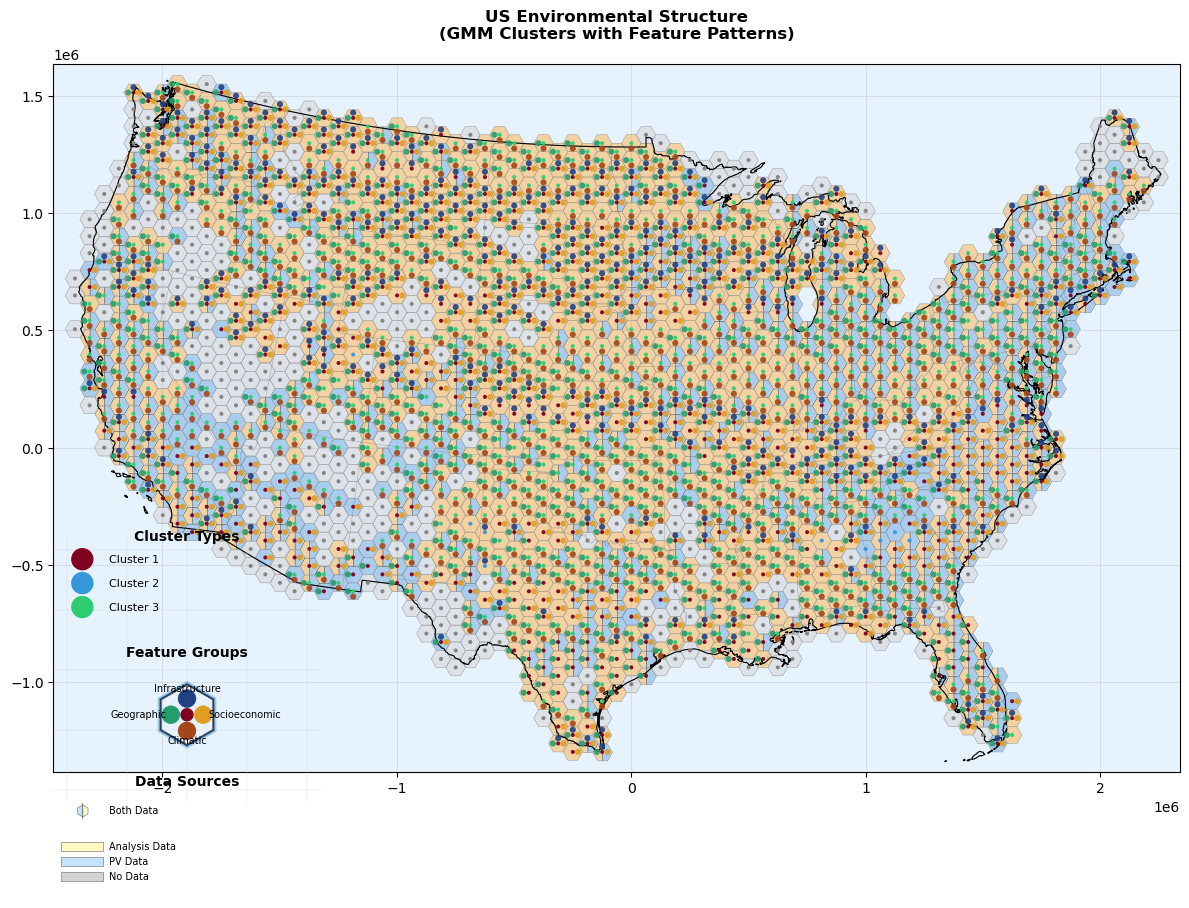

In [61]:

from matplotlib.collections import CircleCollection
from tqdm import tqdm  

def plot_hexagonal_gmm_map(hex_gdf,
                           us_states_gdf,
                           us_nation,
                           df_embedding_fill=None,
                           df_analysis=None,
                           cluster_colors=None,
                           pattern_colors=None,
                           save_path='figure/US_figure/hexagonal_gmm_environmental_structure.png',
                           pattern_threshold=0.25,
                           circle_scale=1.0):
    """
    优化版：使用 CircleCollection 批量绘制
    """
    print("\n=== Creating Hexagonal GMM Map (Optimized) ===")

    if cluster_colors is None:
        cluster_colors = {
            0: '#E74C3C',
            1: '#3498DB',
            2: '#2ECC71',
        }
    if pattern_colors is None:
        pattern_colors = {
            'Socioeconomic': '#f6c96c',
            'Infrastructure': '#8fd2f1',
            'Geographic': '#33d6a5',
            'Climatic': '#e9834c',
        }

    unique_clusters = sorted(set(cluster_colors.keys()) &
                             set(hex_gdf['dominant_cluster'].unique()))

    fig, ax = plt.subplots(1, 1, figsize=(12, 10))
    ax.set_facecolor('#e6f3ff')

    # 投影到 Albers
    hex_albers = hex_gdf.to_crs('ESRI:102003')
    states_albers = us_states_gdf.to_crs('ESRI:102003')
    nation_albers = us_nation.to_crs('ESRI:102003')

    xmin, ymin, xmax, ymax = hex_albers.total_bounds
    margin = 50000.0
    ax.set_xlim(xmin - margin, xmax + margin)
    ax.set_ylim(ymin - margin, ymax + margin)

    states_albers.plot(ax=ax, color='none', edgecolor='gray',
                       linewidth=0.3, alpha=0.4, zorder=1)
    nation_albers.plot(ax=ax, color='none', edgecolor='black',
                       linewidth=0.8, zorder=2)

    # 移除PV site散点部分（原第56-65行删除）

    print(f"Plotting {len(hex_albers)} hexagons...")

    # bbox in display pixels
    (x0_px, y0_px), (x1_px, y1_px) = ax.transData.transform([(xmin, ymin), (xmax, ymax)])
    data_w_m = (xmax - xmin)
    data_h_m = (ymax - ymin)
    px_per_m_x = (x1_px - x0_px) / data_w_m if data_w_m > 0 else 1.0
    px_per_m_y = (x1_px - y0_px) / data_h_m if data_h_m > 0 else 1.0
    px_per_m = (px_per_m_x + px_per_m_y) / 2.0

    # 关键：points/px = 72 / fig.dpi
    pts_per_m = px_per_m * (72.0 / fig.dpi)
    print(f"Conversion factor: {pts_per_m:.6f} points/meter")
    

    # 批量计算所有 hex 的中心和半径
    hex_info = []
    for idx, row in hex_albers.iterrows():
        geom = row['geometry']
        if geom.is_empty:
            continue
        centroid = geom.centroid
        cx, cy = centroid.x, centroid.y

        # 取外环顶点，找与中心距离最大的那个（对规则六边形即为中心到顶点距离=边长）
        coords = list(geom.exterior.coords)
        if not coords:
            continue
        dists = [np.hypot(x - cx, y - cy) for (x, y) in coords]
        hex_radius_m = float(np.max(dists))  # 中心到顶点距离 = 六边形边长
        base_r_m = hex_radius_m * circle_scale          # 你想要的 cluster circle 半径
        pattern_r_m = base_r_m * 1.5                   # 可按需调整

        cluster_id = int(row.get('dominant_cluster', -1))
        pattern_shares = {
            col.replace('pattern_', '').replace('_share', ''): float(row[col])
            for col in hex_gdf.columns
            if col.startswith('pattern_') and col.endswith('_share') and np.isfinite(row[col])
        }
        hex_info.append({
            'idx': idx,
            'center': (cx, cy),
            'geometry': geom,  
            'base_r_meters': base_r_m,
            'pattern_r_meters': pattern_r_m,
            'cluster_id': cluster_id,
            'pattern_shares': pattern_shares,
        })

    # 批量判断 hex 的数据类型
    hex_with_analysis = set()
    hex_with_pv = set()
    
    # 判断 df_analysis 数据
    if df_analysis is not None and 'lat' in df_analysis.columns and 'lon' in df_analysis.columns:
        gdf_analysis = gpd.GeoDataFrame(
            df_analysis,
            geometry=gpd.points_from_xy(df_analysis.lon, df_analysis.lat),
            crs='EPSG:4326'
        ).to_crs('ESRI:102003')
        
        try:
            joined = gpd.sjoin(
                gdf_analysis,
                hex_albers,
                how='inner',
                predicate='within'
            )
            hex_with_analysis = set(joined.index_right)
        except Exception:
            pass
    
    # 判断 df_embedding_fill 数据
    if df_embedding_fill is not None and 'lat' in df_embedding_fill.columns and 'lon' in df_embedding_fill.columns:
        gdf_pv = gpd.GeoDataFrame(
            df_embedding_fill,
            geometry=gpd.points_from_xy(df_embedding_fill.lon, df_embedding_fill.lat),
            crs='EPSG:4326'
        ).to_crs('ESRI:102003')
        
        try:
            joined = gpd.sjoin(
                gdf_pv,
                hex_albers,
                how='inner',
                predicate='within'
            )
            hex_with_pv = set(joined.index_right)
        except Exception:
            pass

    # 分类 hex：只analysis、只pv、都有、都没有
    hex_only_analysis = hex_with_analysis - hex_with_pv
    hex_only_pv = hex_with_pv - hex_with_analysis
    hex_both = hex_with_analysis & hex_with_pv
    hex_neither = set(hex_albers.index) - (hex_with_analysis | hex_with_pv)

    # 绘制不同类型 hex 的底色（注意：将set转换为list），使用黑色边框
    if hex_only_analysis:
        hex_albers.loc[list(hex_only_analysis)].plot(
            ax=ax, color='#FFB347', edgecolor='black', linewidth=0.3, alpha=0.5, zorder=0.5  # 偏橙色
        )
    if hex_only_pv:
        hex_albers.loc[list(hex_only_pv)].plot(
            ax=ax, color='#6FA8DC', edgecolor='black', linewidth=0.3, alpha=0.5, zorder=0.5
        )
    
    if hex_neither:
        hex_albers.loc[list(hex_neither)].plot(
            ax=ax, color='lightgray', edgecolor='black', linewidth=0.3, alpha=0.5, zorder=0.5
        )
    
    # 特殊处理：都有的 hex - 绘制半边六边形
    if hex_both:
        from shapely.geometry import Polygon, LineString
        for idx in hex_both:
            # 从 hex_info 中获取几何体
            hex_data = next((info for info in hex_info if info['idx'] == idx), None)
            if hex_data is None:
                continue
            
            hex_geom = hex_data['geometry']
            if hex_geom.is_empty:
                continue
            
            centroid = hex_geom.centroid
            cx, cy = centroid.x, centroid.y
            
            # 获取六边形的y范围（用于确定分割线的合理长度）
            miny, maxy = hex_geom.bounds[1], hex_geom.bounds[3]
            y_range = maxy - miny
            padding = y_range * 0.2  # 添加20%的padding确保完全覆盖
            
            # 创建分割线（垂直线，将六边形分成左右两半）
            # 使用六边形的实际y范围 + padding
            half_line = LineString([(cx, miny - padding), (cx, maxy + padding)])
            
            # 在地图上绘制灰色分割线（只在六边形内部可见的部分）
            # 将分割线与六边形求交，得到实际在六边形内的线段
            visible_line = half_line.intersection(hex_geom.boundary)
            if visible_line.is_empty:
                # 如果交为空，说明线段在六边形内，直接绘制整个线段
                xs, ys = half_line.xy
                ax.plot(xs, ys, color='gray', linewidth=1.0, zorder=1)
            elif visible_line.geom_type in ['LineString', 'MultiLineString']:
                # 绘制与边界的交点处的短线
                if visible_line.geom_type == 'LineString':
                    xs, ys = visible_line.xy
                    ax.plot(xs, ys, color='gray', linewidth=1.0, zorder=1)
                else:
                    for line in visible_line.geoms:
                        xs, ys = line.xy
                        ax.plot(xs, ys, color='gray', linewidth=1.0, zorder=1)
            
            # 创建左右两个半多边形
            try:
                # 左半边（x < cx）
                left_poly = hex_geom.intersection(Polygon([
                    (hex_geom.bounds[0] - 1000, miny - 1000),
                    (cx, miny - 1000),
                    (cx, maxy + 1000),
                    (hex_geom.bounds[0] - 1000, maxy + 1000)
                ]))
                
                # 右半边（x >= cx）
                right_poly = hex_geom.intersection(Polygon([
                    (cx, miny - 1000),
                    (hex_geom.bounds[2] + 1000, miny - 1000),
                    (hex_geom.bounds[2] + 1000, maxy + 1000),
                    (cx, maxy + 1000)
                ]))
                
                # 绘制左半边：橙色 (#FFA95E)
                if not left_poly.is_empty and left_poly.area > 0:
                    gpd.GeoSeries([left_poly], crs=hex_albers.crs).plot(
                        ax=ax, color='#FFB347', edgecolor='black', linewidth=0.3, alpha=0.5, zorder=0.5
                    )
                
                # 绘制右半边：蓝色 (#6FA8DC)
                if not right_poly.is_empty and right_poly.area > 0:
                    gpd.GeoSeries([right_poly], crs=hex_albers.crs).plot(
                        ax=ax, color='#6FA8DC', edgecolor='black', linewidth=0.3, alpha=0.5, zorder=0.5
                    )
            except Exception as e:
                # 如果分割失败，使用整个六边形填充
                hex_albers.loc[[idx]].plot(
                    ax=ax, color='#d4e3d4', edgecolor='black', linewidth=0.3,
                    alpha=0.8, zorder=0.5
                )
    
    # 绘制六边形边线（所有 hex）
    hex_albers.plot(ax=ax, color='none', edgecolor='white', linewidth=0.1, zorder=0.6)

    # 批量收集所有要绘制的圆
    cluster_circles = []
    pattern_circles = []

    offsets = {
        'Socioeconomic': ( 2.7,  0),
        'Infrastructure': ( 0,  2.7),
        'Geographic':    (-2.7,  0),
        'Climatic':      ( 0, -2.7),
    }

    for info in hex_info:
        x, y = info['center']
        has_data = info['idx'] in (hex_with_analysis | hex_with_pv)

        r_pts = info['base_r_meters'] * pts_per_m
        area_pts2 = np.pi * (r_pts ** 2)
        cluster_color = cluster_colors.get(info['cluster_id'], '#808080') if has_data else '#808080'

        # 总是绘制 cluster circle
        cluster_circles.append({'xy': (x, y), 'area_pts2': area_pts2, 'c': cluster_color})

        # 只对有数据的 hex 绘制 pattern circles
        if has_data:
            for pname, share in info['pattern_shares'].items():
                if share < pattern_threshold or pname not in offsets:
                    continue
                dx, dy = offsets[pname]
                x_pat = x + dx * info['base_r_meters']
                y_pat = y + dy * info['base_r_meters']
                r_pat_pts = info['pattern_r_meters'] * pts_per_m
                area_pat_pts2 = np.pi * (r_pat_pts ** 2)
                pattern_circles.append({'xy': (x_pat, y_pat), 'area_pts2': area_pat_pts2,
                                        'c': pattern_colors.get(pname, '#808080')})

    if cluster_circles:
        cluster_xy = np.array([c['xy'] for c in cluster_circles])
        cluster_sizes = np.array([c['area_pts2'] for c in cluster_circles])
        coll = CircleCollection(
            cluster_sizes,
            offsets=cluster_xy,
            transOffset=ax.transData,
            facecolors=[c['c'] for c in cluster_circles],
            edgecolors='none',
            linewidths=0.6,
            alpha=0.95,
            zorder=10,
        )
        ax.add_collection(coll)

    if pattern_circles:
        pattern_xy = np.array([c['xy'] for c in pattern_circles])
        pattern_sizes = np.array([c['area_pts2'] for c in pattern_circles])
        coll = CircleCollection(
            pattern_sizes,
            offsets=pattern_xy,
            transOffset=ax.transData,
            facecolors=[c['c'] for c in pattern_circles],
            edgecolors='none',
            linewidths=0.4,
            alpha=0.9,
            zorder=9,
        )
        ax.add_collection(coll)


    legend_ax = add_legend_panel(fig, cluster_colors, pattern_colors, unique_clusters)
    
    ax.set_title('US Environmental Structure\n(GMM Clusters with Feature Patterns)',
                 fontsize=12, fontweight='bold', pad=18)
    plt.tight_layout()
    
    print(f"Saving to: {save_path}")
    fig.savefig(save_path, dpi=300, bbox_inches='tight', facecolor='white')
    pdf_path = save_path.replace('.png', '.pdf')
    fig.savefig(pdf_path, bbox_inches='tight', facecolor='none')
    print(f"Saving to: {pdf_path}")
    
    return fig, ax


# Cluster 3: 1256 hexagons (44.6%)
# Cluster 1: 21 hexagons (0.7%)
# Cluster 2: 1537 hexagons (54.6%)
# hex_gdf_h4.head()
fig, ax = plot_hexagonal_gmm_map(
    hex_gdf_h4,
    us_states,
    us_nation,
    df_embedding_fill=df_embedding_fill,
    df_analysis=df_analysis,
    cluster_colors={
        0: '#800020',     # 酒红色
        1: '#3498DB',     # 蓝色
        2: '#2ECC71',     # 绿色
    },
    pattern_colors={
        # 深色版: Socioeconomic, Infrastructure, Geographic, Climatic
        'Socioeconomic': '#e09e21',   # 深金色
        'Infrastructure': '#224183',  # 深蓝色
        'Geographic': '#229d6e',      # 深绿色
        'Climatic': '#a34618',        # 深橙棕色
    },
    pattern_threshold=0.3,
    circle_scale=0.2,
    save_path='figure/US_figure/hexagonal_gmm_environmental_structure.png',
)

<Axes: >

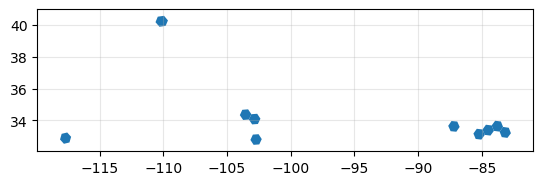

In [63]:
hex_gdf_h4[hex_gdf_h4['dominant_cluster'] == 1].plot()

# 3、环境结构图

In [66]:
import geopandas as gpd
from shapely.geometry import Point
from function import *

us_nation = gpd.read_file(r'data\US_data\cb_2018_us_nation_5m.shp')
us_states = gpd.read_file(r'data\cb_2018_us_state_500k.shp')
us_counties = gpd.read_file('data/cb_2018_us_county_500k.shp')
us_argscv = gpd.read_file("figure/draw_shp/ASD_2012_5m.shp")


us_nation_4326 = us_nation.to_crs('EPSG:4326')
us_states_4326 = us_states.to_crs('EPSG:4326')
us_counties_4326 = us_counties.to_crs('EPSG:4326')
us_argscv_4326 = us_argscv.to_crs('EPSG:4326')

def clip_data_with_us_states(df, us_states_gdf, lon_col='lon', lat_col='lat'):
    """
    使用美国州界 shapefile 剪裁点数据；兼容不同版本的 geopandas 参数名
    """
    geometry = [Point(xy) for xy in zip(df[lon_col], df[lat_col])]
    gdf = gpd.GeoDataFrame(df, geometry=geometry, crs='EPSG:4326')
    us_states_4326 = us_states_gdf.to_crs('EPSG:4326')

    try:
        clipped = gpd.sjoin(gdf, us_states_4326, how='inner', predicate='within')
    except TypeError:
        # 旧版本 geopandas 使用 op 参数
        clipped = gpd.sjoin(gdf, us_states_4326, how='inner', op='within')

    # 清理 shapefile 附加字段
    clipped = clipped.drop(columns=['geometry', 'index_right'], errors='ignore')
    for col in us_states_gdf.columns:
        if col in clipped.columns:
            clipped = clipped.drop(columns=[col], errors='ignore')
    return clipped

# ---------------------------
# 0) 基础地理范围与底图
# ---------------------------
usa_bounds_main = dict(lon_min=-125, lon_max=-65, lat_min=25, lat_max=49)
# ---------------------------
# 1) 读取数据
# ---------------------------
df_abandon = load_abandon(PATHS['us_abandon'])
df_embedding = load_embedding(PATHS['us_pv_embedding'])
df_net_benefit = pd.read_csv('data/US_data/df_net_benefit.csv')

# 初步经纬度范围过滤
df_embedding = df_embedding[
    (df_embedding['lon'] >= usa_bounds_main['lon_min']) &
    (df_embedding['lon'] <= usa_bounds_main['lon_max']) &
    (df_embedding['lat'] >= usa_bounds_main['lat_min']) &
    (df_embedding['lat'] <= usa_bounds_main['lat_max'])
]
df_abandon = df_abandon[
    (df_abandon['lon'] >= usa_bounds_main['lon_min']) &
    (df_abandon['lon'] <= usa_bounds_main['lon_max']) &
    (df_abandon['lat'] >= usa_bounds_main['lat_min']) &
    (df_abandon['lat'] <= usa_bounds_main['lat_max'])
]

# 第二次用州界矢量更精确裁剪
df_abandon = clip_data_with_us_states(df_abandon, us_nation)
df_embedding = clip_data_with_us_states(df_embedding, us_nation)

# ---------------------------
# 2) 缺失值填充 + 去重
# ---------------------------
df_abandon_fill   = fill_nonpositive_with_nearest(df_abandon)
df_embedding_fill = fill_nonpositive_with_nearest(df_embedding)

df_abandon_filtered = filter_duplicates(df_abandon_fill, df_embedding_fill)
df_abandon_filtered=df_abandon_filtered.merge(df_net_benefit[['lon', 'lat', 'area_m2']], on=['lat', 'lon'], how='left')
features_no_coords = [f for f in (NUMERIC_FEATURES + CAT_COLS) if f not in ['lat', 'lon']]
features_no_coords = [c for c in features_no_coords if c in df_embedding_fill.columns]



You want to predict the year: 2020.0
列 GDPpc 没有需要填充的非正值或NaN值
列 GDPpc 没有需要填充的非正值或NaN值


## 2.1 PV环境结构组合

In [ ]:
manual_cluster_patterns = {
    1: {
        'blocks': [
            {
                'pattern': 'Socioeconomic',
                'arrow_color': '#8B0000',
                'arrow_direction': 'up'
            },
            {
                'pattern': 'Infrastructure',
                'arrow_color': '#8B0000',
                'arrow_direction': 'up'
            }
        ]
    },
    2: {
        'blocks': [
            {
                'pattern': 'Socioeconomic',
                'arrow_color': '#000080',
                'arrow_direction': 'down'
            },
            {
                'pattern': 'Infrastructure',
                'arrow_color': '#000080',
                'arrow_direction': 'down'
            },
            {
                'pattern': 'Geographic',
                'arrow_color': '#000080',
                'arrow_direction': 'up'
            }
        ]
    },
    3: {
        'blocks': [
            {
                
                'pattern': 'Socioeconomic',
                'arrow_color': '#000080',
                'arrow_direction': 'down'
            },
            {
                'pattern': 'Infrastructure',
                'arrow_color': '#000080',
                'arrow_direction': 'down'
            },
            { 
                'pattern': 'Geographic',
                'arrow_color': '#8B0000',
                'arrow_direction': 'up'

            }
        ]
    },
    4: {
        'blocks': [
            {
                'pattern': 'Socioeconomic',
                'arrow_color': '#000080',
                'arrow_direction': 'down'
            },
            {
                'pattern': 'Climatic',
                'arrow_color': '#8B0000',
                'arrow_direction': 'up'
            }
        ]
    }
}



In [ ]:
import joblib
import numpy as np
import matplotlib.pyplot as plt
from sklearn.mixture import GaussianMixture
from sklearn.pipeline import Pipeline
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
from scipy.spatial.distance import pdist
from matplotlib.patches import Rectangle, Patch
import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib import colors
from matplotlib.colors import LinearSegmentedColormap
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from matplotlib.lines import Line2D



def create_cluster_patch_label(ax_cluster, center_x, y_pos, cluster_id, manual_patterns, pattern_colors):
    """

    """

    if cluster_id not in manual_patterns:
        return

    cluster_info = manual_patterns[cluster_id]
    num_blocks = len(cluster_info['blocks'])
    if num_blocks < 1:
        return

    # 单个矩形的宽度和高度
    single_width = 15         
    single_height = 0.8        
    gap = 6  

    # 整个组合Patch的宽度和开始坐标
    total_width = num_blocks * single_width + (num_blocks-1)*gap
    patch_start_x = center_x - total_width/2
    patch_start_y = y_pos - single_height/2

    for i, block_info in enumerate(cluster_info['blocks']):
        pattern_name = block_info['pattern']
        arrow_color = block_info['arrow_color']
        arrow_direction = block_info['arrow_direction']

        color = pattern_colors[pattern_name]
        # 计算每个矩形的x起点
        this_rect_start_x = patch_start_x + i * (single_width + gap)
        rect = Rectangle(
            (this_rect_start_x, patch_start_y),
            single_width,
            single_height,
            facecolor=color,
            edgecolor='white',
            linewidth=0.2
        )
        ax_cluster.add_patch(rect)

        # 在Patch正中间稍微向下添加箭头（三角形），使其高度小于Patch
        arrow_x = this_rect_start_x + single_width / 2
        arrow_y = patch_start_y + single_height / 2 - 0.22 * single_height

        arrow_area = single_width * single_height * 1.5  # 经验系数，保证适度
        arrow_size = min(arrow_area, 15)

        if arrow_direction == "up":
            ax_cluster.scatter(
                arrow_x, arrow_y, 
                marker='^', s=arrow_size, c=arrow_color,
                edgecolors='white', zorder=20, linewidths=0.3, alpha=0.95
            )
        elif arrow_direction == "down":
            ax_cluster.scatter(
                arrow_x, arrow_y, 
                marker='v', s=arrow_size, c=arrow_color,
                edgecolors='white', zorder=20, linewidths=0.3, alpha=0.95
            )

    # 在组合Patch下方添加Cluster ID
    # 定义每个Cluster对应的百分比字符串
    # 优化版：显示样本数和百分比（数量参考：3325, 4086, 1540, 1211）
    cluster_percent_info = {
        1: "\n32.65%",
        2: "\n40.25%",
        3: "\n15.17%",
        4: "\n11.93%"
    }
    percent_str = cluster_percent_info.get(cluster_id, "")
    # 显示Cluster ID和百分比
    ax_cluster.text(
        center_x, patch_start_y - 0.3,
        f'Cluster {cluster_id}{percent_str}', 
        ha='center', va='top', fontsize=5, fontweight='bold'
    )


def draw_connectors(fig, ax_ref, ax_top, ax_bottom, centers, color='0.75', lw=0.6, alpha=0.35):
    """
    在 figure 坐标系画竖线，连接 ax_top 的底边 ↔ ax_bottom 的顶边。
    ax_ref: 用来把数据x转换到屏幕坐标的参考轴（和 centers 的坐标系一致，通常是 ax_heatmap）
    centers: 各 component 的数据坐标 x 中心（如 [(i+0.5)*10 for i in range(n)]）
    """
    inv = fig.transFigure.inverted()
    # 两个轴在 figure 中的矩形位置
    y0 = ax_bottom.get_position().y1   # heatmap 顶边
    y1 = ax_top.get_position().y0      # pattern 底边
    for x in centers:
        # 数据坐标 -> 显示坐标 -> Figure 坐标
        x_disp = ax_ref.transData.transform((x, 0))[0]
        x_fig = inv.transform((x_disp, 0))[0]
        line = Line2D([x_fig, x_fig], [y0, y1],
                      transform=fig.transFigure, color="gray", lw=lw, alpha=alpha,
                      zorder=5)  # zorder 可调：大一点在前，小一点在后
        fig.add_artist(line)

def plot_gmm_component_patterns(
    model_path: str = "gmm_model_23c_fixed.pkl",
    save_path: str = None,
):
    """GMM Component-Feature Pattern可视化（优化版 - 等高度模式条+横向图例+聚类边界）"""
    
    # ========== 加载模型 ==========
    gmm_pipeline = joblib.load(model_path)
    gmm: GaussianMixture = gmm_pipeline.named_steps['gmm']
    preprocessor = gmm_pipeline.named_steps['preprocessor']
    
    means = gmm.means_
    weights = gmm.weights_
    covariances = gmm.covariances_
    n_components = gmm.n_components
    
    # ========== 特征处理 ==========
    numeric_features = preprocessor.numeric_features
    categorical_features = preprocessor.categorical_features
    n_numeric = len(numeric_features)
    
    if categorical_features:
        landcover_means = means[:, n_numeric:]
        dominant_landcover_values = np.take_along_axis(
            landcover_means, 
            np.argmax(landcover_means, axis=1)[:, np.newaxis], 
            axis=1
        ).squeeze()
        component_features_std = np.column_stack([
            means[:, :n_numeric], 
            dominant_landcover_values[:, np.newaxis]
        ])
        n_landcover_cats = landcover_means.shape[1]
    else:
        component_features_std = means
        landcover_means = None
    
    all_features = numeric_features + categorical_features
    
    # ========== 方差提取 ==========
    if gmm.covariance_type == 'full':
        variances = np.array([np.diag(covariances[k]) for k in range(n_components)])
    elif gmm.covariance_type == 'diag':
        variances = covariances
    else:
        variances = np.ones_like(means)
    
    if categorical_features:
        landcover_variances = variances[:, n_numeric:]
        variances_for_display = np.column_stack([
            variances[:, :n_numeric],
            landcover_variances.mean(axis=1, keepdims=True)
        ])
    else:
        variances_for_display = variances
    
    # ========== 定义模式和颜色（使用Okabe-Ito配色） ==========
    feature_groups = {
        'Socioeconomic': ['Population', 'GDPpc', 'GDPtot', 'GURdist'],
        'Infrastructure': ['Powerdist', 'PrimaryRoad', 'SecondaryRoad', 'TertiaryRoad'],
        'Geographic': ['DEM', 'Slope', 'gdmp'],
        'Climatic': ['rsds', 'tas', 'wind'],
    }
    
    # 改为稍微浅一点的颜色，浅20%左右
    pattern_colors = {
        'Socioeconomic': '#f6c96c',  # 浅橙色
        'Infrastructure': '#8fd2f1',  # 浅蓝色
        'Geographic': '#33d6a5',     # 浅绿色
        'Climatic': '#e9834c',       # 浅红棕色
    }
    
    landcover_to_pattern = {
        1: ['Socioeconomic'], 2: ['Geographic'], 3: ['Geographic'],
        4: ['Geographic'], 5: ['Geographic'], 6: ['Climatic'],
        7: ['Socioeconomic', 'Infrastructure'], 8: ['Geographic'], 9: ['Climatic'],
    }
    
    # ========== 计算模式得分并归一化（直接方法） ==========
    def calculate_pattern_weights(comp_idx):
        """计算并返回归一化的模式权重"""
        scores = {name: 0.0 for name in feature_groups.keys()}

        # 对于每个特征，先取该component在该特征上的（标准化）均值绝对值，反映该特征在该component上的显著性。
        # 再乘以该特征的标准差（以sqrt(方差)计算），反映特征在该component内的离散度（特征的丰富度）。
        # 再乘以当前component的权重（weights[comp_idx]），保证整体的贡献度与component重要性相乘。
        # 上述乘积，对该pattern下所有相关特征求和，作为该pattern在此component下的总体贡献。
        for pattern_name, features in feature_groups.items():
            indices = [all_features.index(f) for f in features if f in all_features]
            if indices:
                # 累加pattern对应特征的贡献分数
                scores[pattern_name] += (
                    np.abs(component_features_std[comp_idx, indices]) * 
                    np.sqrt(variances_for_display[comp_idx, indices]) * 
                    weights[comp_idx]
                ).sum()
        
        # Landcover贡献
        if landcover_means is not None:
            for lc_idx in range(n_landcover_cats):
                lc_class = lc_idx + 1
                if lc_class in landcover_to_pattern:
                    patterns = landcover_to_pattern[lc_class]
                    lc_contrib = (
                        np.abs(landcover_means[comp_idx, lc_idx]) * 
                        np.sqrt(landcover_variances[comp_idx, lc_idx]) * 
                        weights[comp_idx]
                    )
                    for pattern in patterns:
                        if pattern in scores:
                            scores[pattern] += lc_contrib / len(patterns)
        
        # 归一化为权重（总和=1）
        total = sum(scores.values())
        if total > 1e-10:
            weights_dict = {k: v/total for k, v in scores.items()}
        else:
            weights_dict = {k: 0.25 for k in scores.keys()}  # 均分
        
        return weights_dict
    
    # 计算所有components的模式权重
    pattern_weights_list = []
    for k in range(n_components):
        pattern_weights_list.append(calculate_pattern_weights(k))
    
    # ========== 层次聚类 ==========
    distance_matrix = pdist(component_features_std, metric='correlation')
    linkage_matrix = linkage(distance_matrix, method='ward')
    # 获取聚类标签（以distance=1.5为阈值）
    cluster_labels = fcluster(linkage_matrix, t=1.5, criterion='distance')
    # 识别类别边界
    def find_cluster_boundaries(dendro_order, cluster_labels):
        """识别聚类边界点"""
        boundaries = []
        current_cluster = cluster_labels[dendro_order[0]]
        
        for i in range(1, len(dendro_order)):
            if cluster_labels[dendro_order[i]] != current_cluster:
                boundaries.append(i )  # 边界在两个component之间
                current_cluster = cluster_labels[dendro_order[i]]
        
        return boundaries
    
    # ========== 可视化 ==========
    mm_to_inch = 1/25.4
    fig = plt.figure(figsize=(92*mm_to_inch, 80*mm_to_inch)) 
    
    plt.rcParams.update({
        'font.size': 6, 'axes.titlesize': 5, 'axes.labelsize': 5,
        'xtick.labelsize': 5, 'ytick.labelsize': 5, 'legend.fontsize': 5,
        'font.family': 'Arial'
    })
    
    # 调整布局：移除第4个子图，压缩热力图高度
    gs = gridspec.GridSpec(4, 1, height_ratios=[0.3, 0.25, 1.2, 0.15], hspace=0.05, 
                    left=0.15, right=0.82, top=0.95, bottom=0.05)

    # --- 树状图 ---
    plt.rcParams['lines.linewidth'] = 1
    ax_dendro = fig.add_subplot(gs[0])
    dendro = dendrogram(
        linkage_matrix, 
        ax=ax_dendro, 
        no_labels=True,
        color_threshold=0, 
        above_threshold_color='gray'
    )
    
    # 获取dendro_order和边界
    dendro_order = dendro['leaves']
    boundaries = find_cluster_boundaries(dendro_order, cluster_labels)
    
    # 打印聚类信息
    print("=== 聚类分析结果 ===")
    print(f"聚类数量: {len(set(cluster_labels))}")
    print(f"边界位置: {boundaries}")
    
    # 按聚类分组显示components
    clusters = {}
    for i, comp_idx in enumerate(dendro_order):
        cluster_id = cluster_labels[comp_idx]
        if cluster_id not in clusters:
            clusters[cluster_id] = []
        clusters[cluster_id].append(f'C{comp_idx}')
    
    for cluster_id, components in clusters.items():
        print(f"Cluster {cluster_id}: {components}")

    # 完全移除所有文字和标签
    ax_dendro.set_xticks([])
    ax_dendro.set_yticks([])
    ax_dendro.set_ylabel('')
    ax_dendro.set_xlabel('')
    ax_dendro.set_title('')
    # 仅设置底部ticks可见，但不显示label
    ax_dendro.tick_params(axis='x', which='both', bottom=True, top=False, labelbottom=False)
    ax_dendro.tick_params(axis='y', which='both', left=False, right=False, labelleft=False)
    
    # 绘制水平参考线
    ax_dendro.axhline(y=1.5, color='#800000', linestyle='--', linewidth=0.7, alpha=0.7)
    
    ax_dendro.grid(False)

    for spine in ['left','bottom', 'top', 'right']:
        ax_dendro.spines[spine].set_visible(False)

    # --- 模式条（等高度版本：所有柱子高度相同，只显示模式比例） ---
    ax_pattern = fig.add_subplot(gs[1], sharex=ax_dendro)

    # 固定顺序（从下到上）
    pattern_order = ['Socioeconomic', 'Infrastructure', 'Geographic', 'Climatic']

    # 固定柱子高度（不依赖GMM权重）
    fixed_height = 1.0

    for i, comp_idx in enumerate(dendro_order):
        pattern_weights = pattern_weights_list[comp_idx]
        
        cumulative_height = 0
        for pattern_name in pattern_order:
            pattern_ratio = pattern_weights[pattern_name]  # 模式内部比例
            if pattern_ratio > 0.001:  # 只绘制比例>0.1%的部分
                color = pattern_colors[pattern_name]
                segment_height = pattern_ratio * fixed_height  # 等高度模式条
                ax_pattern.add_patch(
                    Rectangle((i*10, cumulative_height), 10, segment_height, 
                            facecolor=color, edgecolor='white', linewidth=0.3)
                )
                cumulative_height += segment_height

    # 在模式条中也绘制垂直边界线
    for boundary in boundaries:
        ax_pattern.axvline(x=boundary*10, color='red', linestyle=':', linewidth=0.8, alpha=0.8)


    # 设置y轴范围（等高度）
    ax_pattern.set_xlim(ax_dendro.get_xlim())
    ax_pattern.set_ylim(0, fixed_height)
    ax_pattern.set_xticks([])
    ax_pattern.set_yticks([])
    ax_pattern.set_ylabel('')
    ax_pattern.set_xlabel('')
    ax_pattern.set_title('')
    ax_pattern.tick_params(axis='both', which='both',
                     bottom=True, top=False, left=False, right=False,
                     labelbottom=False, labelleft=False)
    for spine in ax_pattern.spines.values():
        spine.set_visible(False)
    
    # --- 图例放在ax_pattern右侧 ---
    legend_elements = [Patch(facecolor=color, label=pattern, edgecolor="white")
                   for pattern, color in pattern_colors.items()]

    ax_pattern.text(
        1.11, 1.05, "Environmental\n Structure", 
        transform=ax_pattern.transAxes, fontsize=5, fontweight='bold',
        va='bottom', ha='center'
    )
    ax_pattern.legend(
        handles=legend_elements,
        loc="center left",
        bbox_to_anchor=(1.01, 0.5),
        frameon=False,
        fontsize=5,
        handlelength=1,
        handleheight=0.8,
        labelspacing=0.1,              
        ncol=1,                        
        borderaxespad=0.5,
        handletextpad=0.3
    )

    # --- 热力图 ---
    ax_heatmap = fig.add_subplot(gs[2], sharex=ax_dendro)

    heatmap_data = component_features_std[dendro_order, :].T
    extent = [ax_dendro.get_xlim()[0], ax_dendro.get_xlim()[1], len(all_features), 0]

    # 使用新的配色方案和normalization
    cmap = LinearSegmentedColormap.from_list(
        "blueGreyRed",
        ["#2C7BB6", "#ABD9E9", "#F7F7F7", "#FDAE61", "#D7191C"],
        N=256,
    )
    cmap.set_under("#EDF0F2")
    cmap.set_over("#F3E0DB")
    norm = colors.TwoSlopeNorm(vcenter=0.0, vmin=-3.0, vmax=3.0)

    im = ax_heatmap.imshow(heatmap_data, cmap=cmap, norm=norm, aspect='auto', 
                        interpolation='nearest', extent=extent)

    # === 在每个单元格绘制"填充箭头" ===
    x_centers = np.array([(i + 0.5) * 10 for i in range(n_components)])          # (C,)
    y_centers = np.arange(len(all_features)) + 0.5                               # (F,)
    XX, YY = np.meshgrid(x_centers, y_centers)                                   # (F,C)

    vals = heatmap_data                                                           # (F,C)

    # 计算合适的marker大小 - 基于单元格尺寸
    # 获取热力图的实际像素尺寸
    bbox = ax_heatmap.get_window_extent().transformed(fig.dpi_scale_trans.inverted())
    ax_w_in, ax_h_in = bbox.width, bbox.height

    # 计算每个单元格的像素尺寸
    cell_w_px = (ax_w_in * fig.dpi) / n_components
    cell_h_px = (ax_h_in * fig.dpi) / len(all_features)

    # 设置marker大小为单元格的60-70%，确保不会重叠
    marker_size = min(cell_w_px * 0.65, cell_h_px * 0.65) ** 2

    # 如果计算出的尺寸太小，设置最小尺寸
    min_marker_size = 4 ** 2  # 最小8像素
    marker_size = min(marker_size, min_marker_size)

    print(f"Cell size: {cell_w_px:.1f} x {cell_h_px:.1f} px")
    print(f"Marker size: {marker_size:.1f} points^2")

    # 正值：深红色箭头（向上）
    # 负值：深蓝色箭头（向下）
    pos_colors = '#8B0000'  # 深红色
    neg_colors = '#000080'  # 深蓝色
    mid_color = '#A9A9A9'   # 灰色 横线

    # 设计阈值
    thr = 0.3  # z-score 绝对值阈值，根据效果可以微调

    vals_flat = vals.ravel()
    xx_flat = XX.ravel()
    yy_flat = YY.ravel()

    # 条件掩码
    pos = (vals_flat > thr)        # 显著为正的格点
    neg = (vals_flat < -thr)       # 显著为负的格点
    mid = (~pos) & (~neg)          # 介于+thr和-thr之间

    # 绘制：向上/向下填充三角
    # 正值：向上箭头（深红色）
    ax_heatmap.scatter(xx_flat[pos], yy_flat[pos],
                       marker='^', s=marker_size, c=pos_colors,
                       edgecolors='white', zorder=10, linewidths=0.5, alpha=0.9)

    # 负值：向下箭头（深蓝色）
    ax_heatmap.scatter(xx_flat[neg], yy_flat[neg],
                       marker='v', s=marker_size, c=neg_colors,
                       edgecolors='white', zorder=10, linewidths=0.5, alpha=0.9)

    # 介于+thr和-thr之间：实体横线（灰色）
    # 横线的marker用 '_' （水平线），注意横线比三角marker视觉上短，适当放大
    line_marker_size = marker_size * 1.5
    ax_heatmap.scatter(xx_flat[mid], yy_flat[mid],
                       marker='_', s=line_marker_size, c=mid_color,
                       edgecolors='white', zorder=10, linewidths=1.0, alpha=0.9)

    # 在热力图中也绘制垂直边界线
    for boundary in boundaries:
        ax_heatmap.axvline(x=boundary*10, color='red', linestyle=':', linewidth=0.8, alpha=0.8)

    x_positions = [(i + 0.5) * 10 for i in range(n_components)]

    # x轴标签（显示主导模式，百分比显示）
    labels = []
    for i in range(n_components):
        comp_idx = dendro_order[i]
        labels.append(f'C{comp_idx}')

    ax_heatmap.set_xticks(x_positions)
    ax_heatmap.set_xticklabels(labels, fontsize=4.5, rotation=90, ha='center')
    ax_heatmap.xaxis.set_ticks_position('top')
    ax_heatmap.xaxis.set_label_position('top')
    ax_heatmap.tick_params(
        axis='x', which='both',
        top=True, bottom=False,     # 只留顶部刻度
        labeltop=True, labelbottom=False,
        length=2, pad=2             # 适当留白
    )
    ax_heatmap.tick_params(axis='x', length=2, pad=1)
    ax_heatmap.tick_params(axis='y', length=2, pad=1)  

    ax_heatmap.set_yticks(np.arange(len(all_features)) + 0.5)
    ax_heatmap.set_yticklabels(all_features, fontsize=5)
    ax_heatmap.grid(False, axis='y')  


    # --- 侧边Colorbar（使用新的风格） ---
    cax = inset_axes(
        ax_heatmap,
        width="2%",             # 宽度较窄
        height="60%",           # 高度为热力图高度一半
        loc="upper right",
        bbox_to_anchor=(0.06, -0.3, 1, 1),  # 轻微下移
        bbox_transform=ax_heatmap.transAxes,
        borderpad=0,
    )
    # 标题单独呈现，放在inset_axes上方
    ax_heatmap.text(
        1.1, 0.72, "Standardized\nMean",
        transform=ax_heatmap.transAxes,
        fontsize=5,
        fontweight='bold',
        ha='center',
        va='bottom',
        rotation=0
    )
    cbar = plt.colorbar(im, cax=cax, orientation="vertical", extend='both')
    cbar.ax.tick_params(labelsize=5, direction="out")
    # -- 优化z-score刻度显示，仅显示 3, 0, -3 --
    cbar.set_ticks([-3, 0, 3])
    cbar.outline.set_linewidth(0.6)

    ax_cluster = fig.add_subplot(gs[3], sharex=ax_dendro)
    cluster_ranges = {}
    for i, comp_idx in enumerate(dendro_order):
        cluster_id = cluster_labels[comp_idx]
        if cluster_id not in cluster_ranges:
            cluster_ranges[cluster_id] = {'start': i, 'end': i}
        else:
            cluster_ranges[cluster_id]['end'] = i

    # 略微缩短每个分组线段，对起止x进行微调
    y_center = 0.5
    line_height = 0.3
    x_offset = 5  # 缩短量

    for cluster_id, range_info in cluster_ranges.items():
        start_x = range_info['start'] * 10 + x_offset
        end_x = (range_info['end'] + 1) * 10 - x_offset
        
        # 水平线段
        ax_cluster.plot([start_x, end_x], [y_center, y_center], 
                        color='black', linewidth=1, solid_capstyle='butt')
        
        # 两端垂直线段
        ax_cluster.plot([start_x, start_x], [y_center - line_height/2, y_center + line_height/2], 
                        color='black', linewidth=1)
        ax_cluster.plot([end_x, end_x], [y_center - line_height/2, y_center + line_height/2], 
                        color='black', linewidth=1)
        
        # 聚类中心标签
        center_x = (start_x + end_x) / 2
        create_cluster_patch_label(ax_cluster, center_x, y_center + 0.5, cluster_id, manual_cluster_patterns, pattern_colors)

    # 设置聚类标记图的属性
    ax_cluster.set_xlim(ax_dendro.get_xlim())
    ax_cluster.set_ylim(0, 1)
    ax_cluster.set_xticks([])
    ax_cluster.set_yticks([])
    ax_cluster.set_ylabel('')
    ax_cluster.set_xlabel('')
    ax_cluster.set_title('')

    # 隐藏所有边框
    for spine in ax_cluster.spines.values():
        spine.set_visible(False)
    

    for i in range(n_components):
        x = (i + 0.5) * 10
        ax = ax_pattern  # 只用这一个
        ax.axvline(x=x, color='gray', lw=0.6, alpha=0.35, zorder=4, clip_on=False)


        # 计算每个 component 的中心 x（与你的代码一致）
    x_centers = [(i + 0.5) * 10 for i in range(n_components)]


    draw_connectors(fig, ax_pattern, ax_dendro, ax_pattern, x_centers, color='0.65', lw=1, alpha=1)
    draw_connectors(fig, ax_heatmap, ax_pattern, ax_heatmap, x_centers, color='0.65', lw=1, alpha=1)


    fig.text(
        0.01, 0.99, 'a',
        fontsize=7,
        fontweight='bold',
        va='top',
        ha='left'
    )

    if save_path:
        plt.savefig(save_path, dpi=300)
        print(f"✅ Saved: {save_path}")

    
    return fig


# 使用
if __name__ == "__main__":
    fig = plot_gmm_component_patterns(
        model_path="gmm_model_23c_fixed.pkl",
        save_path="figure/US_figure/component_patterns_final.png"
    )
    plt.show()